## 
    CONUS
    Time period	: 1941 - 2023
    
    location:   s(glost,k=5)  
    
    scale	    s(glost,k=5)  
    shape       1



In [125]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import cftime
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps
from xhistogram.xarray import histogram
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
from copy import copy
from matplotlib import cm

In [126]:
import rpy2
from rpy2.robjects.packages import importr, data
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects import globalenv
pandas2ri.activate()

extRemes = importr("extRemes")
evgam = importr("evgam")
reticulate = importr("reticulate")
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [127]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("cma.mplstyle")

In [128]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

# READ Return_Level files CONUS

In [129]:
yearb=1941
yeare=2023
itest='loc_sc_loess'
domain='CONUS'

lon_min=235;lon_max=293
lat_min=28;lat_max=50

#### Read output from analysis computed by CONUS_ij_NOS_loc_sc_loess_1940-2024.ipynb
file=f'../AFI/{domain}_afi_return.evgam.{yearb}_{yeare}_{itest}.nc'
ds=xr.open_mfdataset(file)
Rlocation   = ds['location']
Rscale      = ds['scale']
Rshape      = ds['shape']
Rrl100      = ds['rl100']
NSlocpvalue = ds['NSlocpvalue']
NSscapvalue = ds['NSscapvalue']
ann_glost = ds['glost']

#### Read AFI data  
#### Needed for point analysis
files=[f'../AFI/AFIT/AFI_ERA5_{iyear}.nc' for iyear in range(yearb,yeare+1)]

dsa=xr.open_mfdataset(files)
dsa=dsa.sortby('lat')
dsa=dsa.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))
dsa['AFI']=dsa['AFI']*5/9.
dsa['time']=np.arange(yearb,yeare+1,1)
dsa = dsa.merge({'glost':ann_glost})

units='degree-days (°C)'
# parameters for smoothness 
%R fmla_gev <- list(AFI ~ s(glost,k=5) , ~ s(glost,k=5) , ~ 1)
spval = -99999
itest=f'{itest}_{yearb}_{yeare}_{domain}'

# Read GEV parameters with scipy.stats.

In [130]:

file0=f'../AFI/afi_return.fullUSA.gev.1980_2008_KS.nc'
ds0=xr.open_dataset(file0)
ds0=ds0.sortby('lat')
ds0=ds0.sel(lon=slice(lon_min,lon_max),lat=slice(lat_min,lat_max))

Slocation = ds0['location']*5/9.
Sshape = ds0['shape']
Sscale = ds0['scale']*5/9.
Srl100 = ds0['return_afi'].sel(return_periods=100)*5/9.

The 100-year return level is expressed in degree-days (C).

In [131]:
cmap200=copy(cm.turbo)
cmap200.set_under('darkgrey', 1.0)
#
cmapBR=copy(cmaps.ncl_default)
cmapBR.set_under('darkgrey', 1.0)
#
cmapBR_r=copy(cmaps.ncl_default_r)
cmapBR_rng=copy(cmaps.ncl_default_r)
cmapBR_r.set_under('darkgrey', 1.0)
#
proj=ccrs.PlateCarree()

# Plot location

<>:49: SyntaxWarning: invalid escape sequence '\d'
<>:52: SyntaxWarning: invalid escape sequence '\d'
<>:49: SyntaxWarning: invalid escape sequence '\d'
<>:52: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/1681689448.py:49: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[ix].get_yticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/1681689448.py:52: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/1681689448.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Purples',len(clevsa)+5)
/v

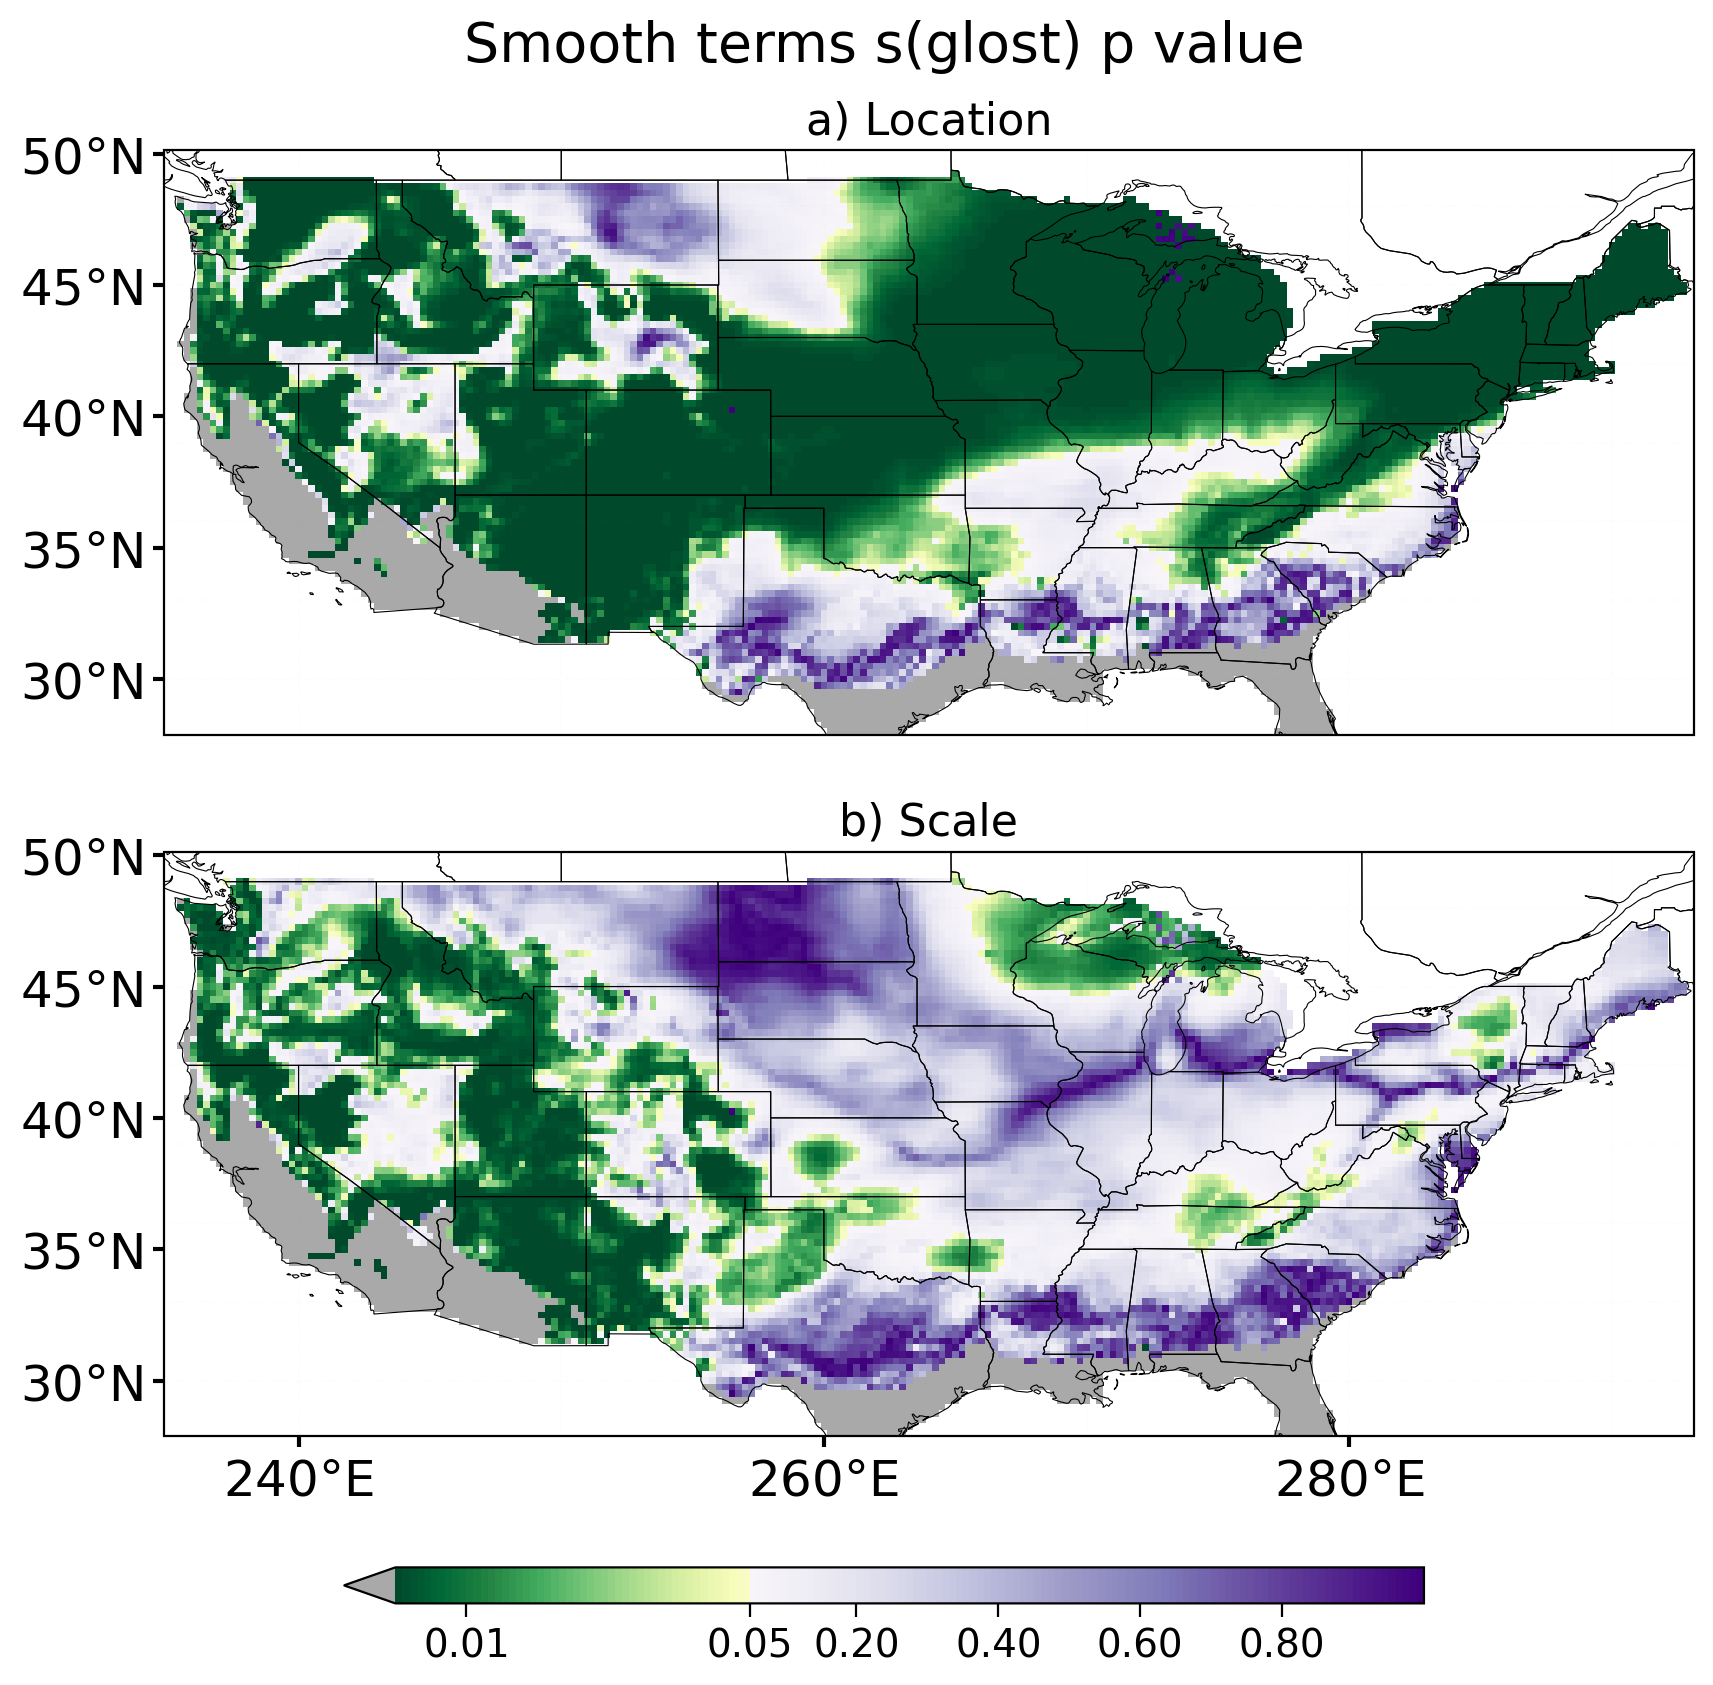

In [132]:
## Build colorbar
clevsa=np.arange(0.06,1.01,0.01)
clevsb=np.arange(0,0.051,0.001)
clevs=np.concatenate((clevsb,clevsa))
cmap = cm.get_cmap('Purples',len(clevsa)+5)
cmaplist = [cmap(i) for i in range(5,cmap.N)]
cmap2 = cm.get_cmap('YlGn_r', len(clevsb)+5)
cmaplist2 = [cmap2(i) for i in range(0,cmap2.N-5)]

my_cmap = colors.LinearSegmentedColormap.from_list('Custom cmap',\
                cmaplist2+cmaplist, len(cmaplist2)+len(cmaplist))

my_cmap.set_under('darkgrey', 1.0)

##########
##########

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(9,9),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,top=0.95, left=0.1,right=0.95,hspace=-0.05)

shrink=0.55
#
#  Location
#

my_cmap.set_under('darkgrey', 1.0)

cc=NSlocpvalue.plot(ax=ax[0],cmap=my_cmap,levels=clevs,add_colorbar=False)
ax[0].set_title('a) Location',fontsize=16)
NSscapvalue.plot(ax=ax[1],cmap=my_cmap,levels=clevs,add_colorbar=False)
ax[1].set_title('b) Scale',fontsize=16)
ax_cbar = fig.add_axes([0.2, 0.1, 0.6, 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar, ticks=[0.01,0.05,0.2,0.4,0.6,0.8],shrink=0.8,location='bottom',orientation='horizontal')
cbar.set_label(label=f'',fontsize=14)
cbar.ax.minorticks_off()
cbar.ax.tick_params(labelsize=14)
####
####
for ix in range(0,len(ax)):
  grd = ax[ix].gridlines(
    draw_labels=False, 
    color='gray', alpha=0.01, linestyle='--')

  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  ax[ix].set_yticks(ax[ix].get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
  ax[ix].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[ix].get_yticks()],size=18)
  if ix == 1: 
    ax[ix].set_xticks(ax[ix].get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
    ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
  else:
    ax[ix].set_xticklabels('') 

fig.suptitle('Smooth terms s(glost) p value',fontsize=20)    
outfile=f'PLOTS/GEV_glost_pvalue_NS{itest}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Map of p-value of the smooth terms for the a) location and b) scale parameters. In grey, not enough AFI values > 0.

<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/2319680397.py:35: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[ix].get_yticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/2319680397.py:38: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)


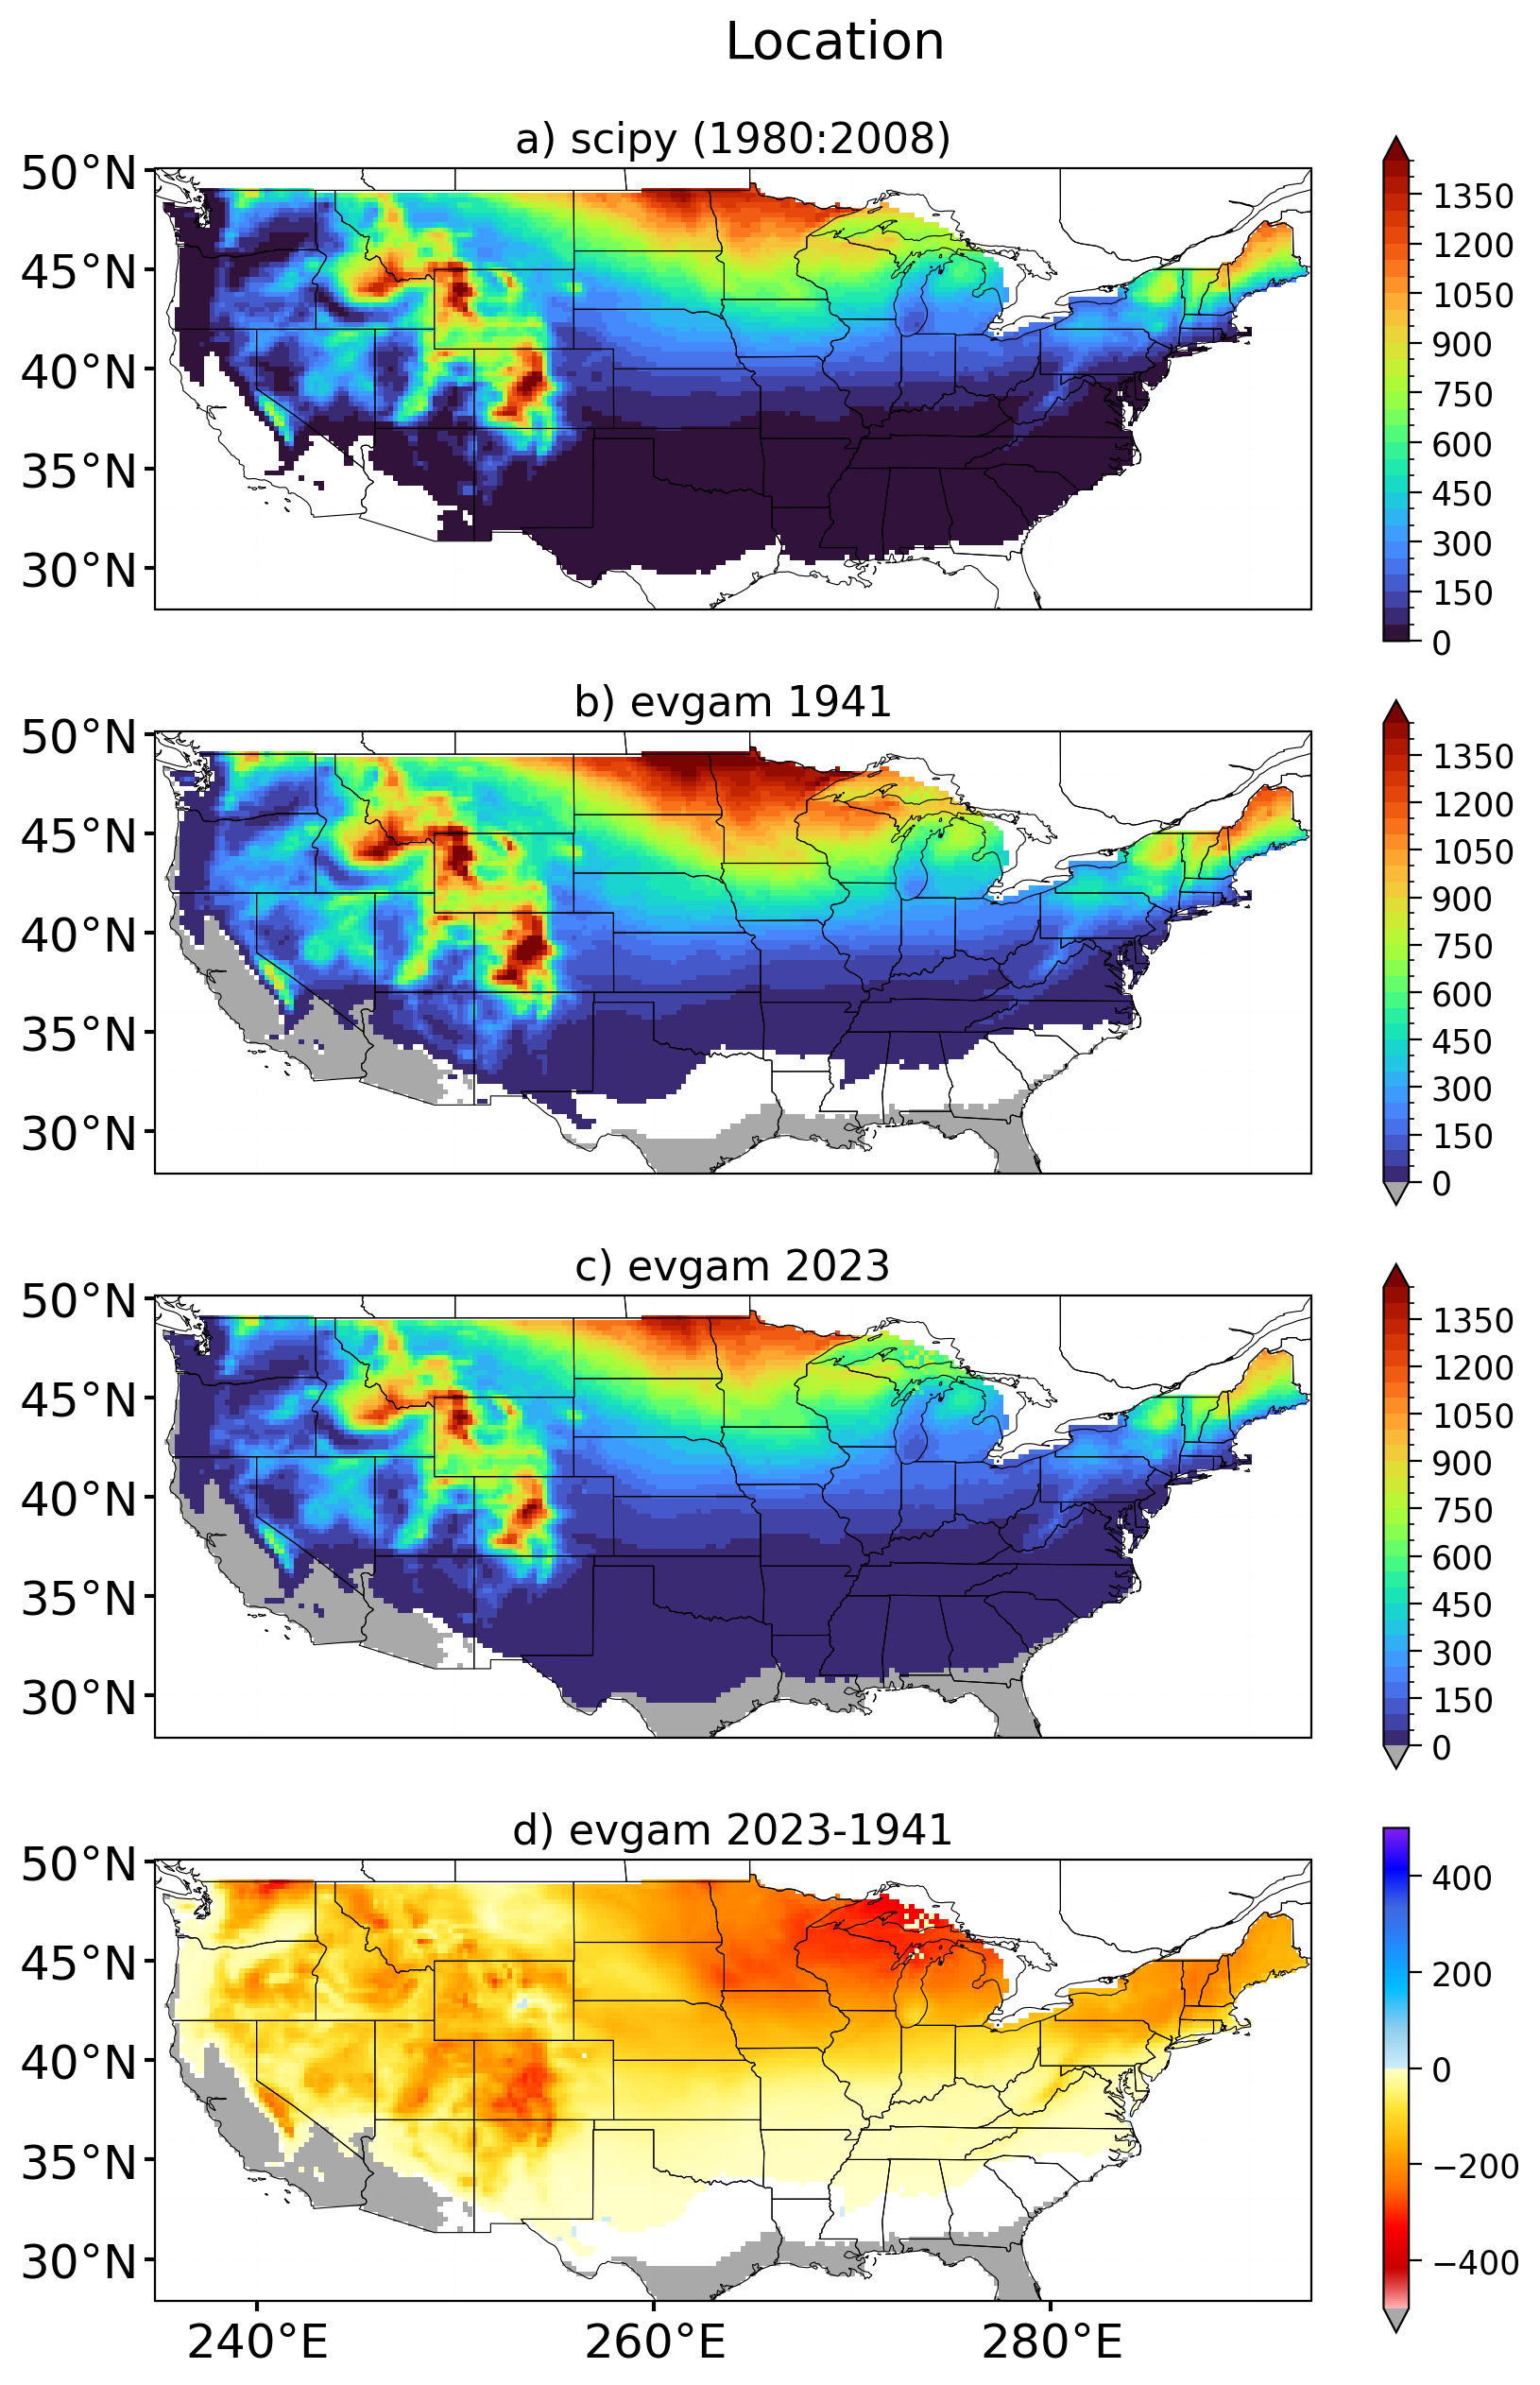

In [133]:

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(9,13),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.02,top=0.95, left=0.1,right=0.95,hspace=-0.05)
ax=ax.flatten()

shrink=0.85
#
#  Location
#
clevs = np.arange(0,1500,50)

Slocation.plot(ax=ax[0],cmap=cmap200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[0].set_title('a) scipy (1980:2008)',fontsize=16)

Rlocation.isel(time=0).plot(ax=ax[1],cmap=cmap200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[1].set_title(f'b) evgam {yearb}',fontsize=16)

Rlocation.isel(time=73).plot(ax=ax[2],cmap=cmap200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[2].set_title(f'c) evgam {yeare}',fontsize=16)

data=Rlocation.isel(time=73)-Rlocation.isel(time=0)
data=xr.where(Rlocation.isel(time=0)==spval,spval,data)
data.plot(ax=ax[3],cmap=cmapBR_r,vmin=-500,vmax=500,cbar_kwargs={'label':'','shrink':shrink})
ax[3].set_title(f'd) evgam {yeare}-{yearb}',fontsize=16)
####
for ix in range(0,len(ax)):
  grd = ax[ix].gridlines(
    draw_labels=False, 
    color='gray', alpha=0.01, linestyle='--')

  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  ax[ix].set_yticks(ax[ix].get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
  ax[ix].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[ix].get_yticks()],size=18)
  if ix == 3: 
    ax[ix].set_xticks(ax[ix].get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
    ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
  else:
    ax[ix].set_xticklabels('')  
fig.suptitle('Location',fontsize=20)    
outfile=f'PLOTS/GEV_location_NS{itest}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')


In [134]:
print(f'Map of location parameters from the GEV analysis performed \n',
f'a) using scipy.stats module over the period 1980-2008,\n',
f'b) using the R-evgam package for the year {yearb},\n',
f'c) using the R-evgam package for the year {yeare},\n',
f'd) using the R-evgam package difference between the years {yeare} and {yearb}.\n',
f'In grey, not enough AFI values > 0.')

Map of location parameters from the GEV analysis performed 
 a) using scipy.stats module over the period 1980-2008,
 b) using the R-evgam package for the year 1941,
 c) using the R-evgam package for the year 2023,
 d) using the R-evgam package difference between the years 2023 and 1941.
 In grey, not enough AFI values > 0.


# Plot Scale

<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/1633631938.py:34: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[ix].get_yticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/1633631938.py:37: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)


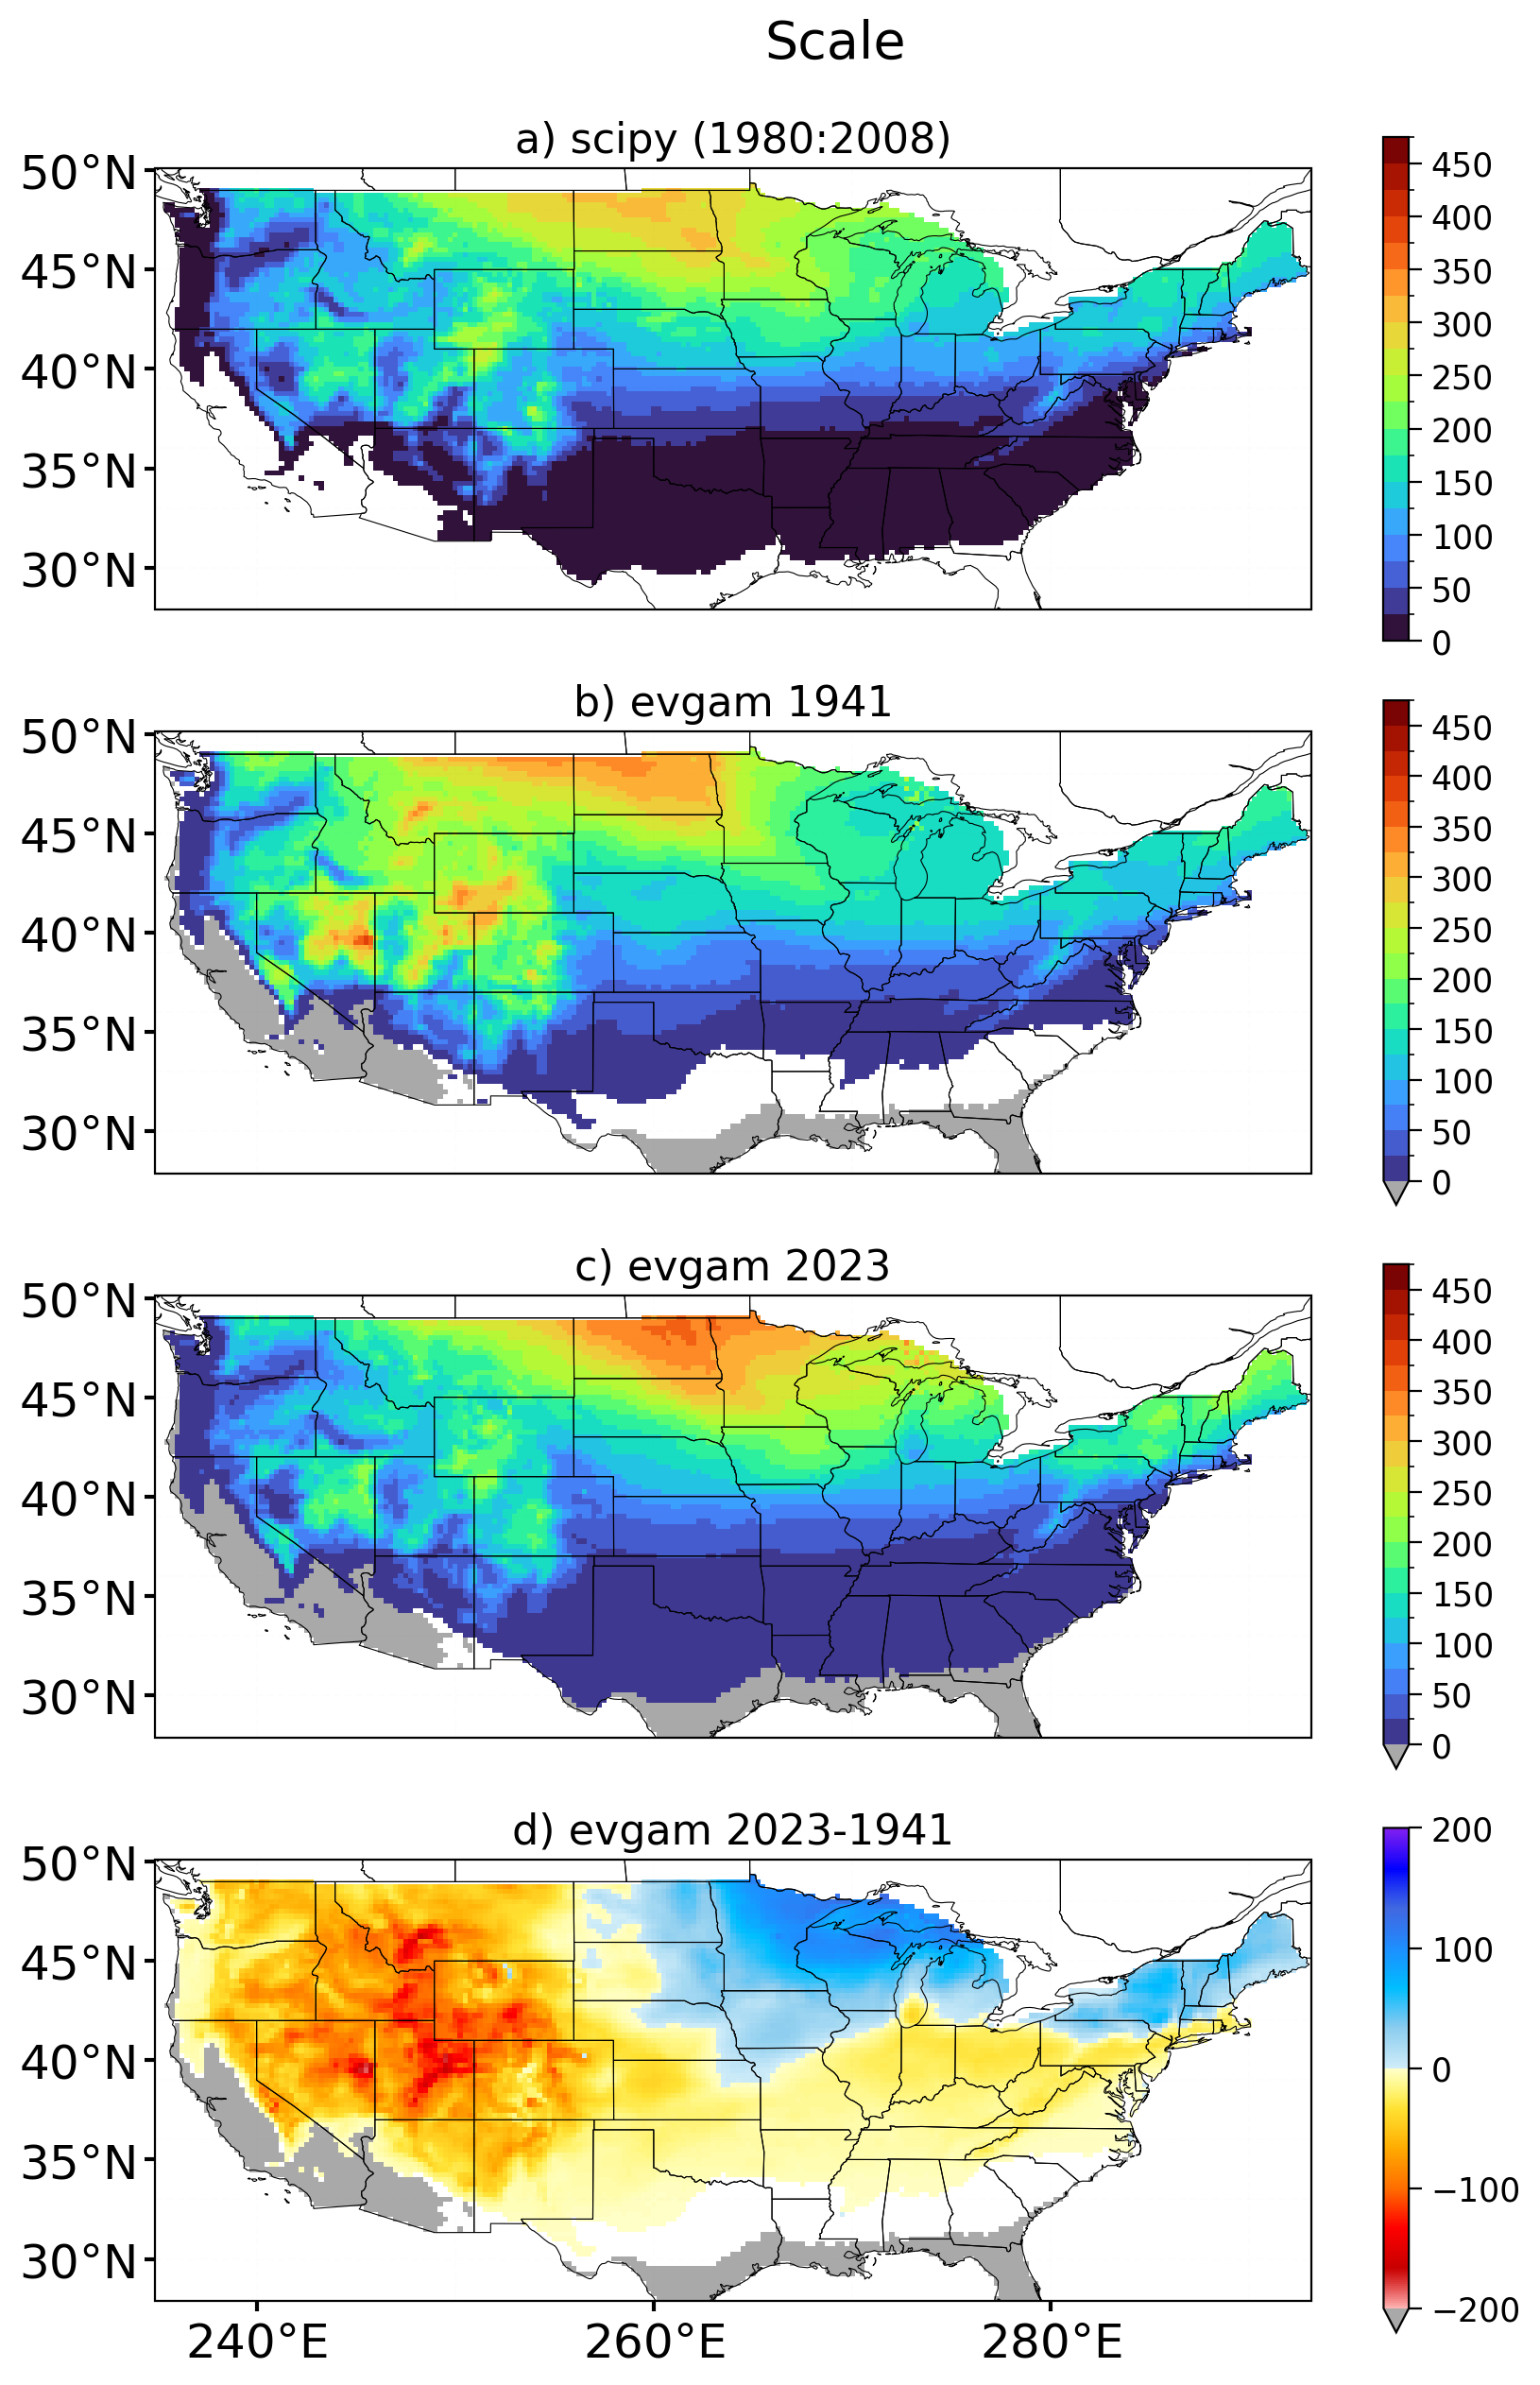

In [135]:
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(9,13),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.02,top=0.95, left=0.1,right=0.95,hspace=-0.05)
ax=ax.flatten()

shrink=0.85
#
#  Scale
#
clevs = np.arange(0,500,25)

Sscale.plot(ax=ax[0],cmap=cmap200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[0].set_title('a) scipy (1980:2008)',fontsize=16)

Rscale.isel(time=0).plot(ax=ax[1],cmap=cmap200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[1].set_title(f'b) evgam {yearb}',fontsize=16)

Rscale.isel(time=73).plot(ax=ax[2],cmap=cmap200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[2].set_title(f'c) evgam {yeare}',fontsize=16)

data=Rscale.isel(time=73)-Rscale.isel(time=0)
data=xr.where(Rscale.isel(time=0)==spval,spval,data)
data.plot(ax=ax[3],cmap=cmapBR_r,vmin=-200,vmax=200,cbar_kwargs={'label':'','shrink':shrink})
ax[3].set_title(f'd) evgam {yeare}-{yearb}',fontsize=16)
####
for ix in range(0,len(ax)):
  grd = ax[ix].gridlines(
    draw_labels=False, 
    color='gray', alpha=0.01, linestyle='--')
  ax[ix].add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  ax[ix].set_yticks(ax[ix].get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
  ax[ix].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[ix].get_yticks()],size=18)
  if ix == 3: 
    ax[ix].set_xticks(ax[ix].get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
    ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
  else:
    ax[ix].set_xticklabels('')  
fig.suptitle('Scale',fontsize=20)    
outfile=f'PLOTS/GEV_scale_NS{itest}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

In [136]:
print(f'Map of scale parameters from the GEV analysis performed \n',
f'a) using scipy.stats module over the period 1980-2008,\n',
f'b) using the R-evgam package for the year {yearb},\n',
f'c) using the R-evgam package for the year {yeare},\n',
f'd) using the R-evgam package difference between the years {yeare} and {yearb}.\n',
f'In grey, not enough AFI values > 0.')

Map of scale parameters from the GEV analysis performed 
 a) using scipy.stats module over the period 1980-2008,
 b) using the R-evgam package for the year 1941,
 c) using the R-evgam package for the year 2023,
 d) using the R-evgam package difference between the years 2023 and 1941.
 In grey, not enough AFI values > 0.


# Plot Shape

<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:40: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:40: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/1190780688.py:37: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[ix].get_yticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/1190780688.py:40: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)


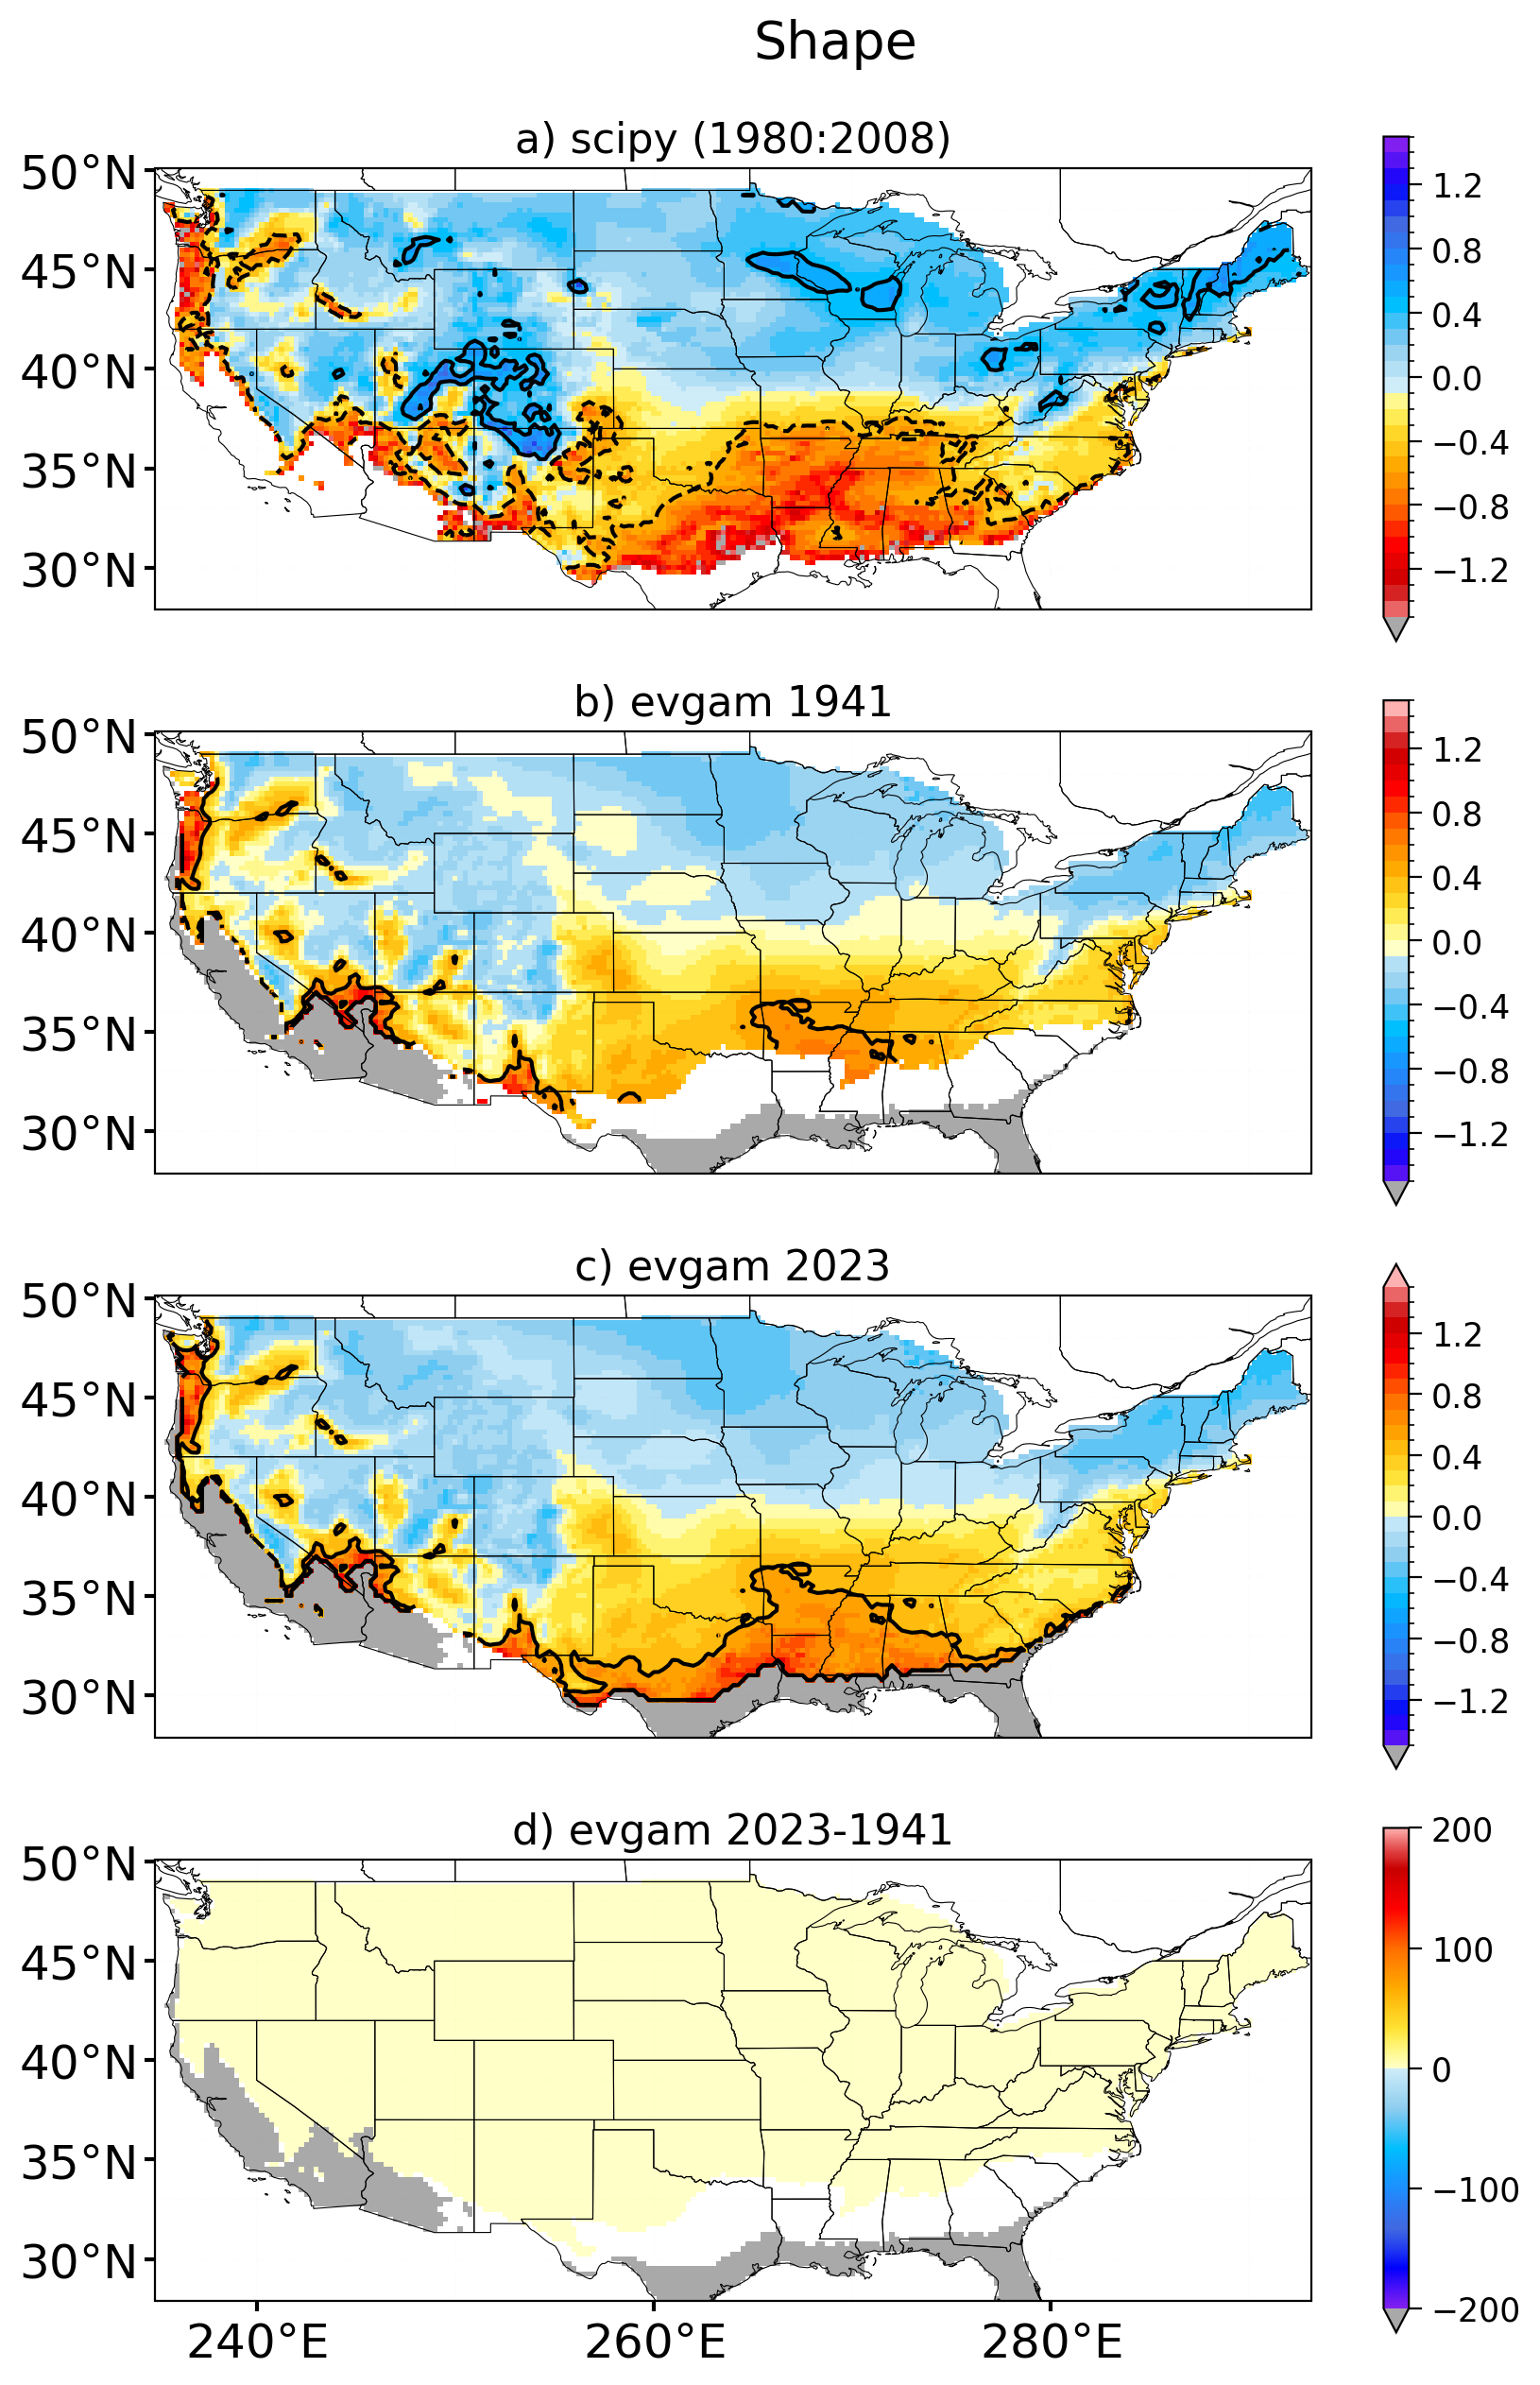

In [137]:
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(9,13),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.02,top=0.95, left=0.1,right=0.95,hspace=-0.05)
ax=ax.flatten()

shrink=0.85
#
#  Scale
#
clevs = np.arange(-1.5,1.6,0.1)

Sshape.plot(ax=ax[0],cmap=cmapBR_r,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[0].contour(Sshape['lon'],Sshape['lat'],Sshape,levels=[-0.5,0.5],colors='k')
ax[0].set_title('a) scipy (1980:2008)',fontsize=16)

Rshape.isel(time=0).plot(ax=ax[1],cmap=cmapBR,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[1].contour(Rshape['lon'],Rshape['lat'],Rshape.isel(time=0),levels=[-0.5,0.5],colors='k')
ax[1].set_title(f'b) evgam {yearb}',fontsize=16)

Rshape.isel(time=73).plot(ax=ax[2],cmap=cmapBR,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[2].contour(Rshape['lon'],Rshape['lat'],Rshape.isel(time=73),levels=[-0.5,0.5],colors='k')
ax[2].set_title(f'c) evgam {yeare}',fontsize=16)

data=Rshape.isel(time=73)-Rshape.isel(time=0)
data=xr.where(Rshape.isel(time=0)==spval,spval,data)
data.plot(ax=ax[3],cmap=cmapBR,vmin=-200,vmax=200,cbar_kwargs={'label':'','shrink':shrink})
ax[3].set_title(f'd) evgam {yeare}-{yearb}',fontsize=16)
####
for ix in range(0,len(ax)):
  grd = ax[ix].gridlines(
    draw_labels=False, 
    color='gray', alpha=0.01, linestyle='--')
  ax[ix].add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  ax[ix].set_yticks(ax[ix].get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
  ax[ix].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[ix].get_yticks()],size=18)
  if ix == 3: 
    ax[ix].set_xticks(ax[ix].get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
    ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
  else:
    ax[ix].set_xticklabels('')  
fig.suptitle('Shape',fontsize=20)    
outfile=f'PLOTS/GEV_shape_NS{itest}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

In [138]:
print(f'Map of shape parameters from the GEV analysis performed \n',
f'a) using scipy.stats module over the period 1980-2008 \n',
'(sign of the shape parameter from scipy is inverse from evgam shape parameter),\n',
f'b) using the R-evgam package for the year {yearb},\n',
f'c) using the R-evgam package for the year {yeare},\n',
f'd) using the R-evgam package difference between the years {yeare} and {yearb}.\n',
f'In grey, not enough AFI values > 0.\n',
f'The black contours are showing the shape parameters contours [-0.5,0.5].')

Map of shape parameters from the GEV analysis performed 
 a) using scipy.stats module over the period 1980-2008 
 (sign of the shape parameter from scipy is inverse from evgam shape parameter),
 b) using the R-evgam package for the year 1941,
 c) using the R-evgam package for the year 2023,
 d) using the R-evgam package difference between the years 2023 and 1941.
 In grey, not enough AFI values > 0.
 The black contours are showing the shape parameters contours [-0.5,0.5].


# Plot 100y Return Level 

<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:41: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:41: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/1880557134.py:38: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[ix].get_yticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/1880557134.py:41: SyntaxWarning: invalid escape sequence '\d'
  ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)


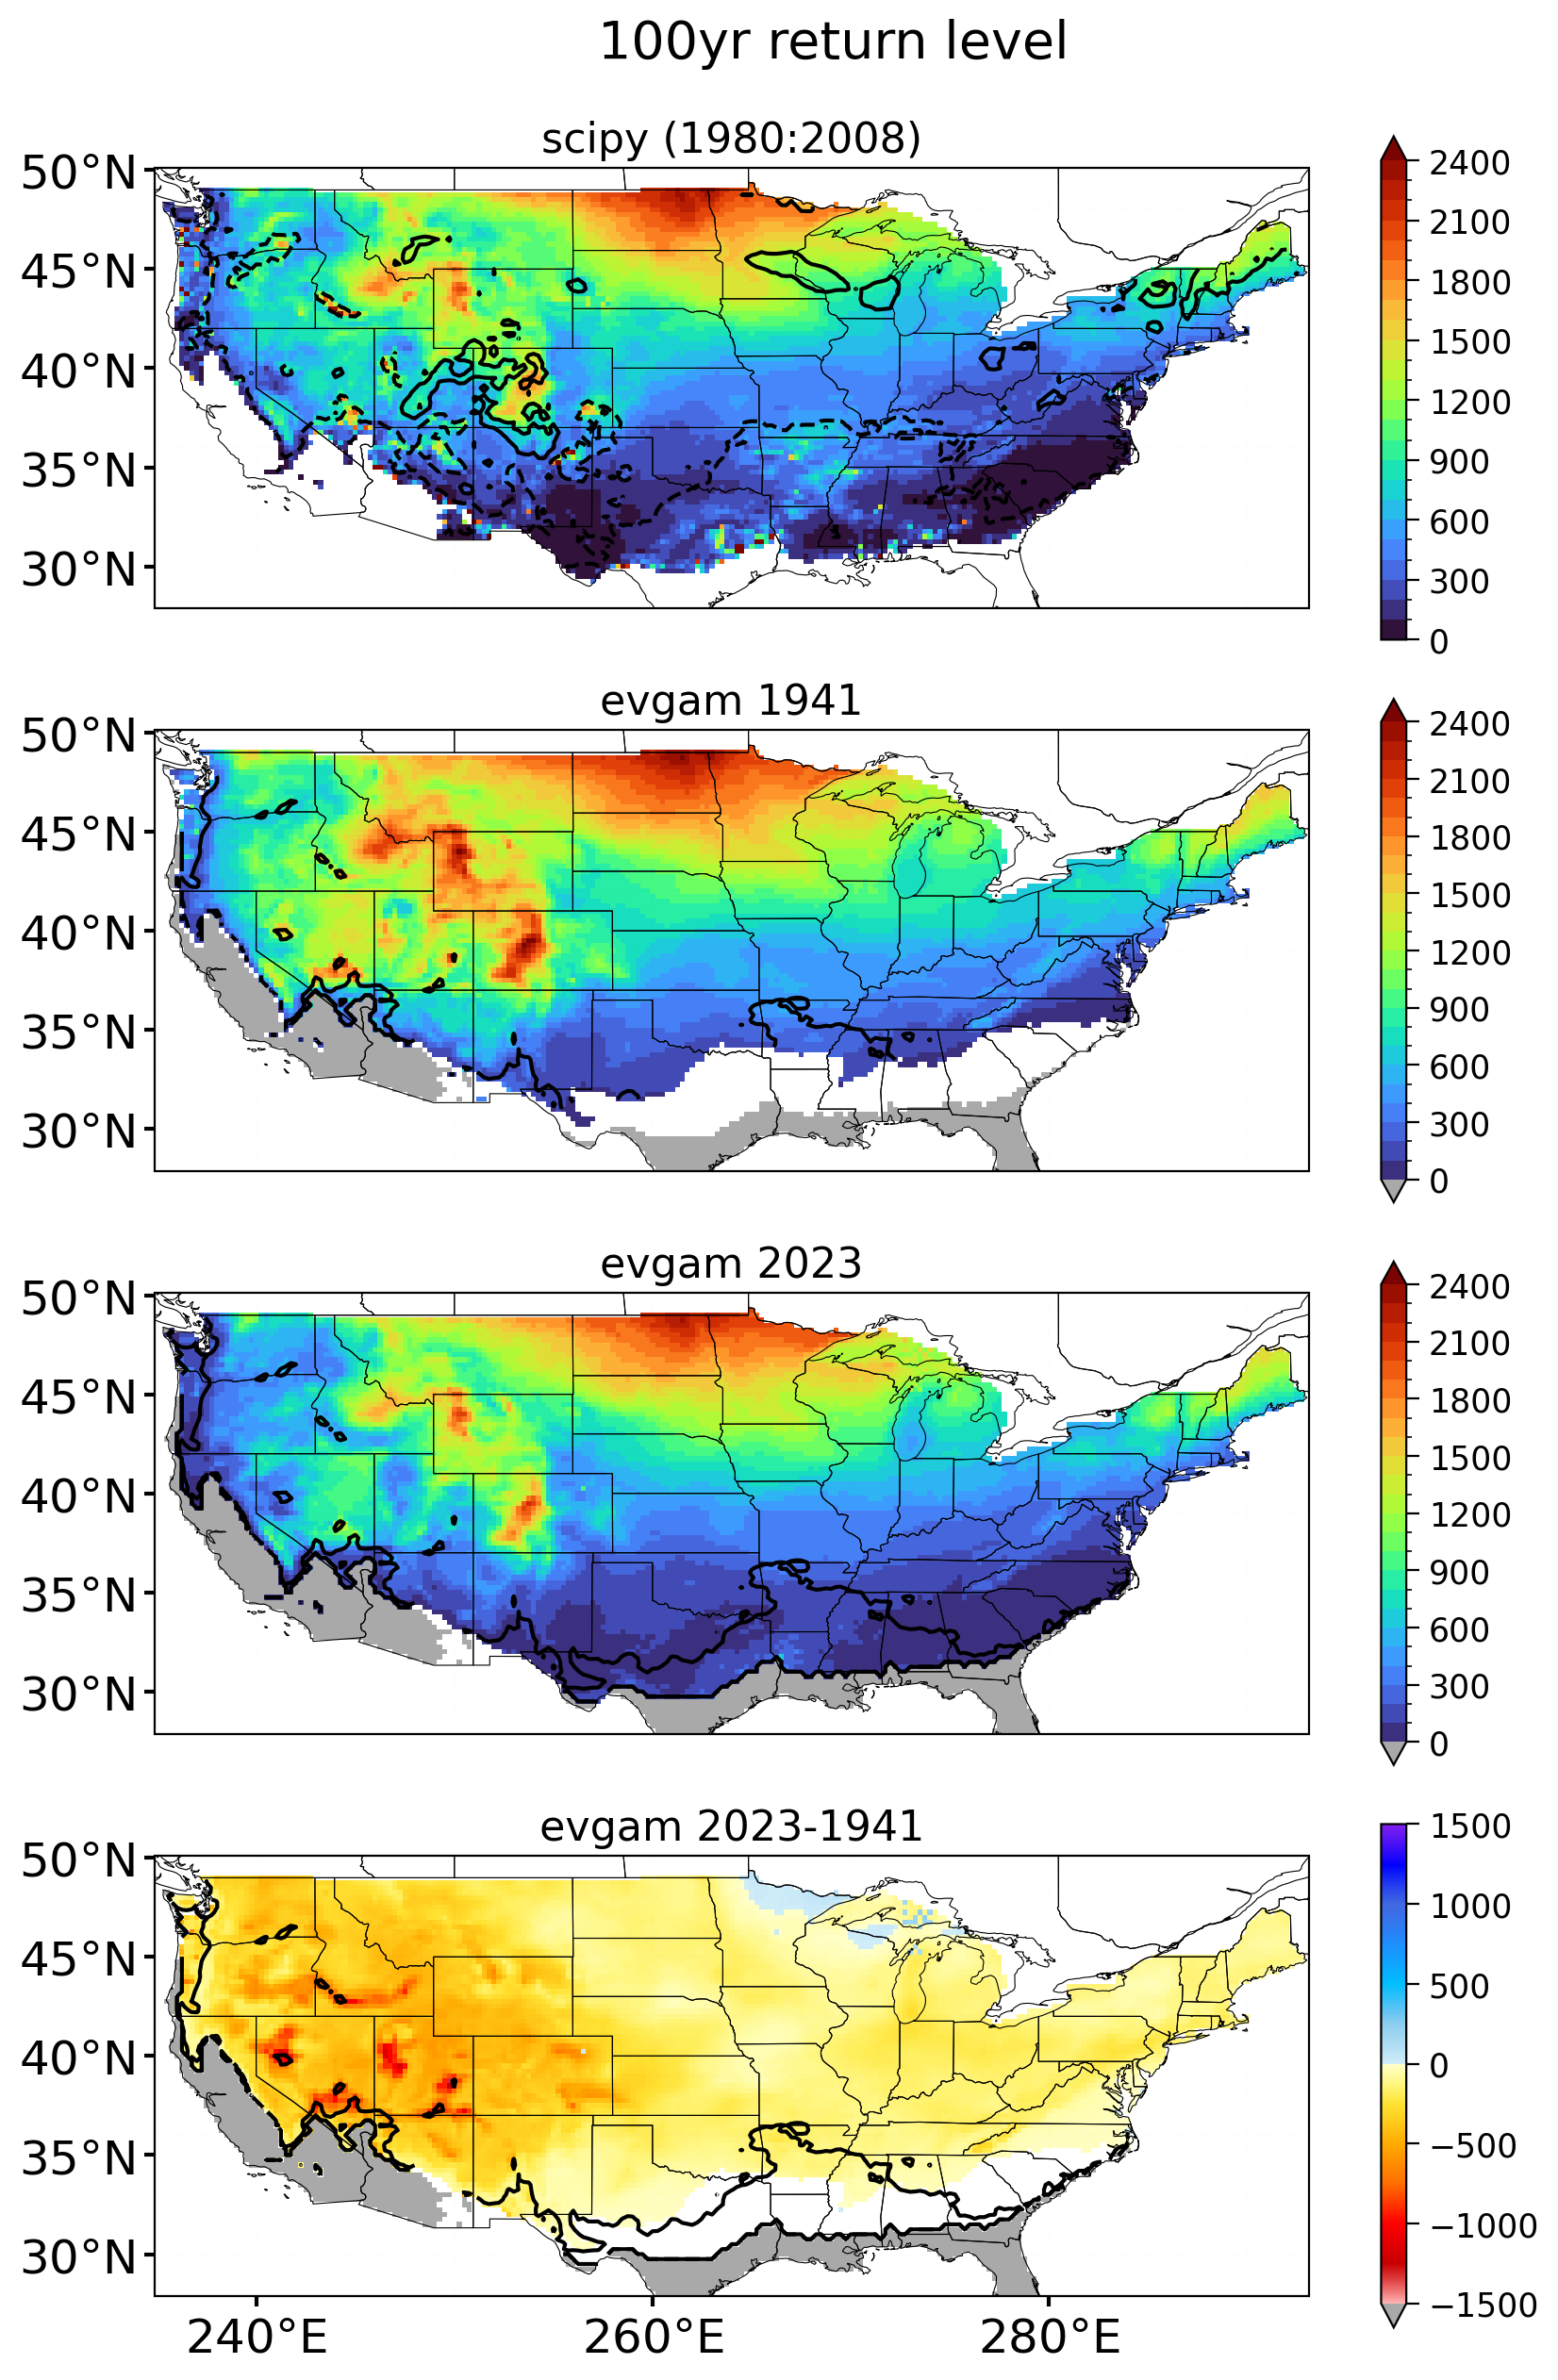

In [139]:
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(9,13),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.02,top=0.95, left=0.1,right=0.95,hspace=-0.05)
ax=ax.flatten()

shrink=0.85
#
#  Scale
#
clevs = np.arange(0,2500,100)

Srl100.plot(ax=ax[0],cmap=cmap200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[0].contour(Sshape['lon'],Sshape['lat'],Sshape,levels=[-0.5,0.5],colors='k')
ax[0].set_title('scipy (1980:2008)',fontsize=16)

Rrl100.isel(time=0).plot(ax=ax[1],cmap=cmap200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[1].contour(Rshape['lon'],Rshape['lat'],Rshape.isel(time=0),levels=[-0.5,0.5],colors='k')
ax[1].set_title(f'evgam {yearb}',fontsize=16)

Rrl100.isel(time=73).plot(ax=ax[2],cmap=cmap200,levels=clevs,cbar_kwargs={'label':'','shrink':shrink})
ax[2].contour(Rshape['lon'],Rshape['lat'],Rshape.isel(time=73),levels=[-0.5,0.5],colors='k')
ax[2].set_title(f'evgam {yeare}',fontsize=16)

data=Rrl100.isel(time=73)-Rrl100.isel(time=0)
data=xr.where(Rrl100.isel(time=0)==spval,spval,data)
data.plot(ax=ax[3],cmap=cmapBR_r,vmin=-1500,vmax=1500,cbar_kwargs={'label':'','shrink':shrink})
ax[3].contour(Rshape['lon'],Rshape['lat'],Rshape.isel(time=73),levels=[-0.5,0.5],colors='k')
ax[3].set_title(f'evgam {yeare}-{yearb}',fontsize=16)
####
for ix in range(0,len(ax)):
  grd = ax[ix].gridlines(
    draw_labels=False, 
    color='gray', alpha=0.01, linestyle='--')
  ax[ix].add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
  ax[ix].set_xlabel('')
  ax[ix].set_ylabel('')
  ax[ix].tick_params(axis='both',direction='out',width=1.5,length=4)
  ax[ix].set_yticks(ax[ix].get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
  ax[ix].set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax[ix].get_yticks()],size=18)
  if ix == 3: 
    ax[ix].set_xticks(ax[ix].get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
    ax[ix].set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax[ix].get_xticks()],size=18)
  else:
    ax[ix].set_xticklabels('')  
fig.suptitle('100yr return level',fontsize=20)    
outfile=f'PLOTS/GEV_rl100_NS{itest}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

In [140]:
print(f'Map of 100 year return-level ({units}) from the GEV analysis performed \n',
f'a) using scipy.stats module over the period 1980-2008,\n',
f'b) using the R-evgam package for the year {yearb},\n',
f'c) using the R-evgam package for the year {yeare},\n',
f'd) using the R-evgam package difference between the years {yeare} and {yearb}.\n',
f'In grey, not enough AFI > 0. for that point.\n',
f'In white, evgam output undefined. The black contours are showing the shape parameters outside of [-0.5,0.5].')

Map of 100 year return-level (degree-days (°C)) from the GEV analysis performed 
 a) using scipy.stats module over the period 1980-2008,
 b) using the R-evgam package for the year 1941,
 c) using the R-evgam package for the year 2023,
 d) using the R-evgam package difference between the years 2023 and 1941.
 In grey, not enough AFI > 0. for that point.
 In white, evgam output undefined. The black contours are showing the shape parameters outside of [-0.5,0.5].


# Bilotta - Like figure 4

min: dask.array<_nanmin_skip-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray> max: dask.array<_nanmax_skip-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


<>:30: SyntaxWarning: invalid escape sequence '\d'
<>:32: SyntaxWarning: invalid escape sequence '\d'
<>:30: SyntaxWarning: invalid escape sequence '\d'
<>:32: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/3345436129.py:30: SyntaxWarning: invalid escape sequence '\d'
  ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/3345436129.py:32: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax.get_xticks()],size=18)


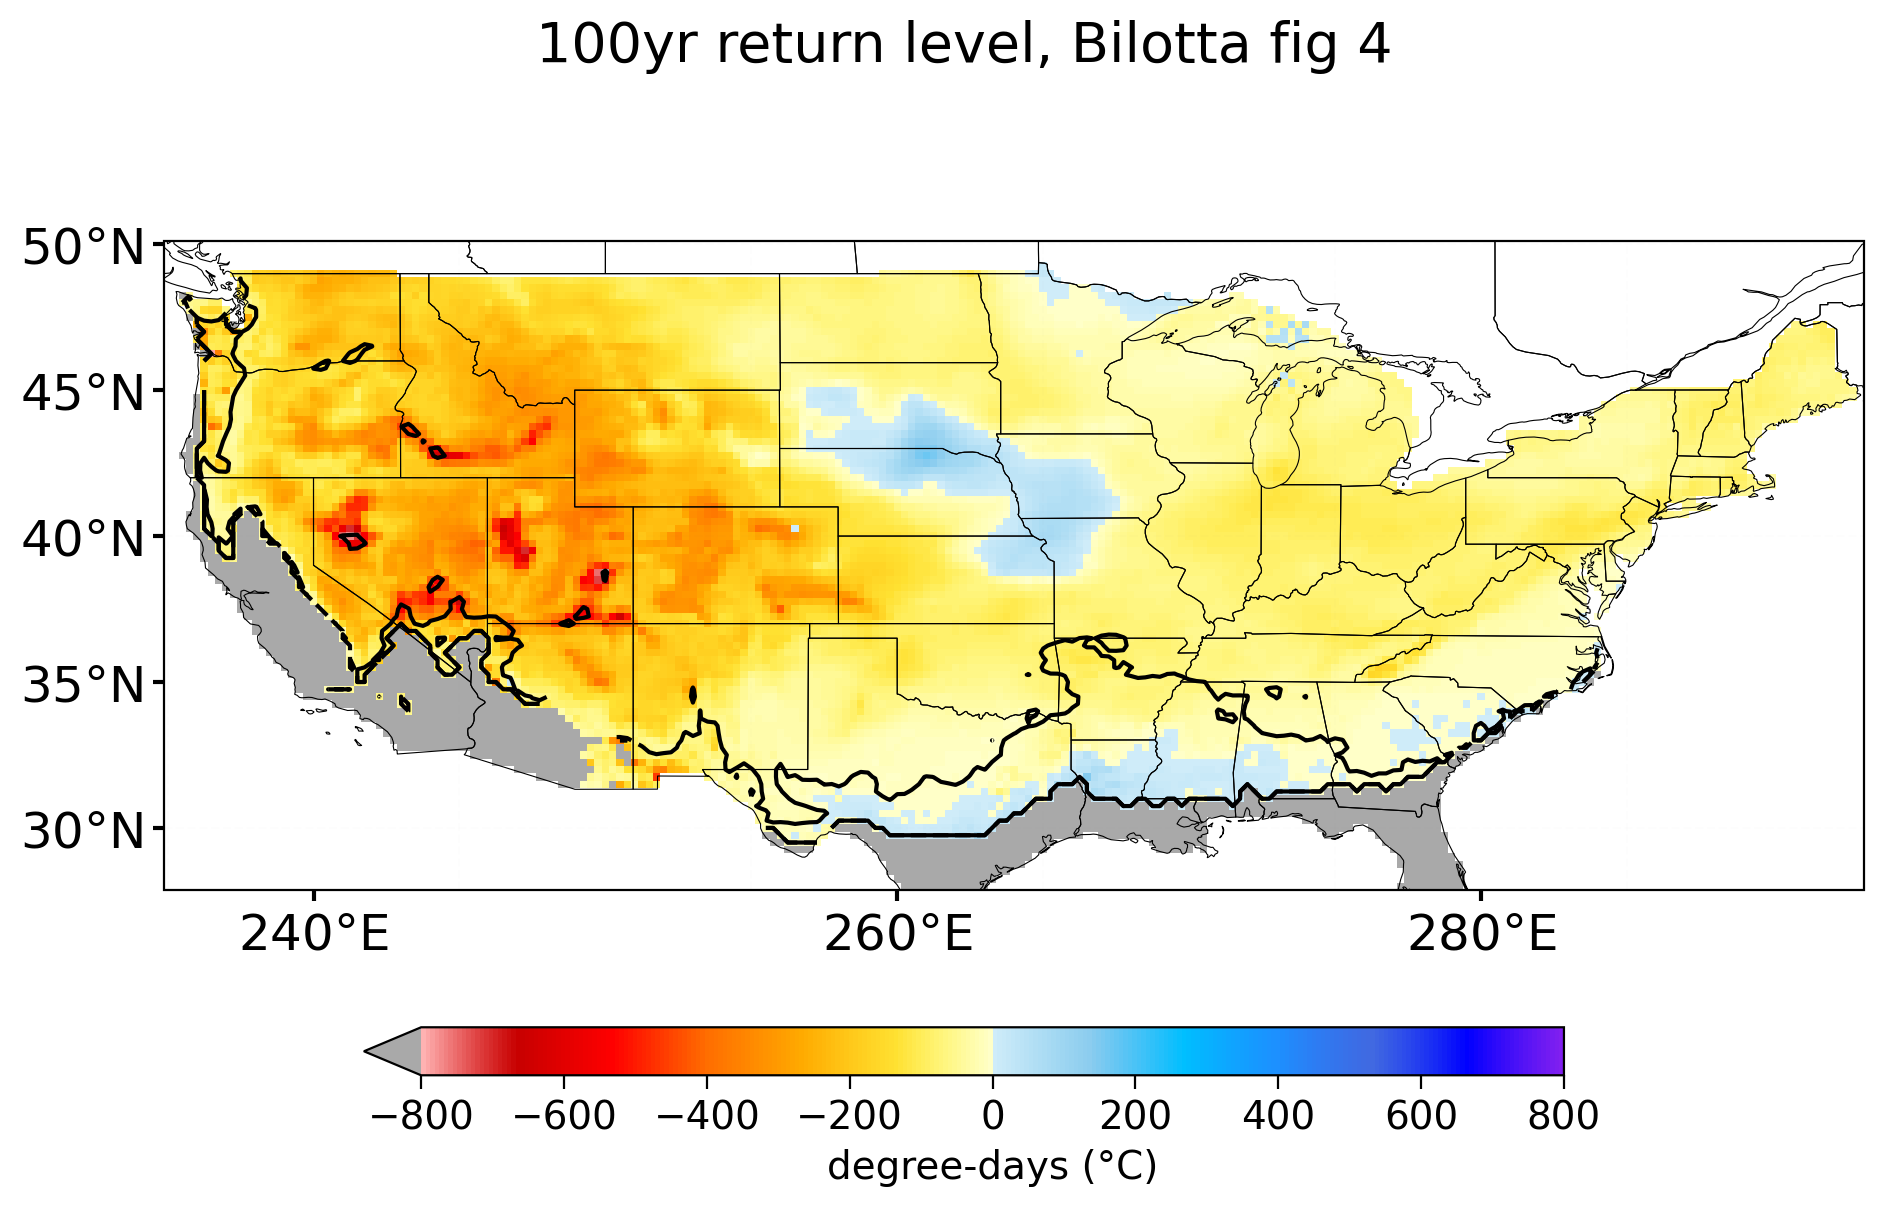

In [141]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15,top=0.9, left=0.1,right=0.95,hspace=-0.05)

shrink=0.65
#
#  Scale
#

data1081 = Rrl100.sel(time=slice(1981,2010)).mean('time')
data8051 = Rrl100.sel(time=slice(1951,1980)).mean('time')
data = data1081 - data8051
print('min:',data.min().data,'max:',data.max().data)
data=xr.where(Rrl100.isel(time=0)==spval,spval,data)
cc = data.plot(ax=ax,cmap=cmapBR_r,vmin=-800,vmax=800,add_colorbar=False)
ax.contour(Rshape['lon'],Rshape['lat'],Rshape.isel(time=73),levels=[-0.5,0.5],\
  colors='k')

grd = ax.gridlines(crs=ccrs.PlateCarree(),
draw_labels=False, 
xlocs=np.arange(-125, -70,10),
ylocs=np.arange(30, 60,10),
color='gray', alpha=0.01, linestyle='--')

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax.get_xticks()],size=18)
ax_cbar = fig.add_axes([0.2, 0.1, 0.6, 0.04])
cbar=fig.colorbar(cc,cax=ax_cbar,extend='min',\
    shrink=0.8,location='bottom',orientation='horizontal')
cbar.set_label(label=f'{units}',fontsize=14)
cbar.ax.minorticks_off()
cbar.ax.tick_params(labelsize=14)
fig.suptitle('100yr return level, Bilotta fig 4',fontsize=20)    
outfile=f'PLOTS/GEV_figure4_NS{itest}.png'
plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')

Differences in the 100-yr return periods calculated using the mean 1981–2010 data vs the mean 1951–80 data. The black contours are showing the shape parameters contours [-0.5,0.5].

# GRID POINTS ANALYSIS

In [142]:
ptlon=[260,261.25]
ptlat=[ 48, 38.  ]

<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/856752879.py:19: SyntaxWarning: invalid escape sequence '\d'
  ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_69723/856752879.py:22: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax.get_xticks()],size=18)


Text(0.5, 1.0, '100yr return level,2023-1941')

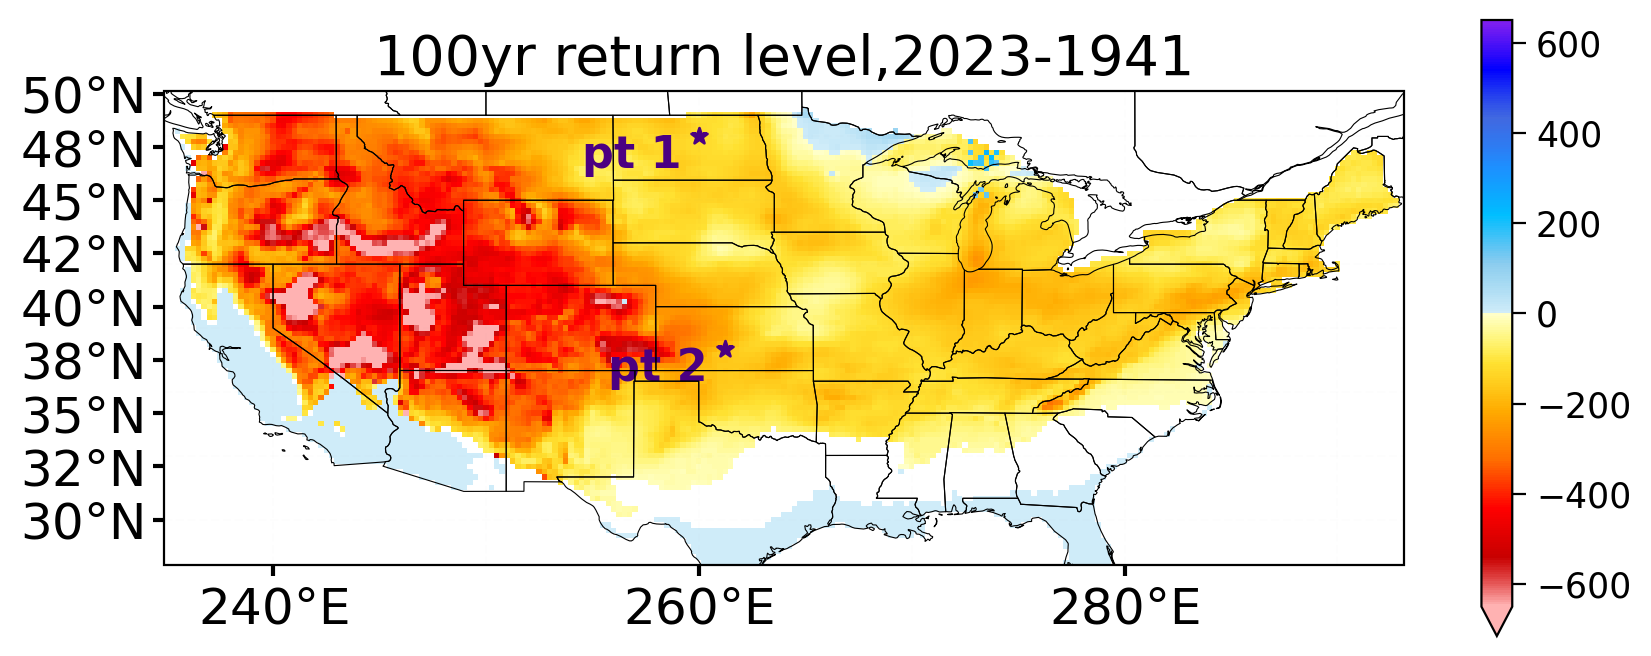

In [143]:
cmap=cmaps.BlGrYeOrReVi200

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,8),subplot_kw={'projection':proj})
data=Rrl100.isel(time=73)-Rrl100.isel(time=0)
#data=xr.where(Rrl100.isel(time=0)==spval,spval,data)
data.plot(cmap=cmapBR_rng,vmin=-650,vmax=650,cbar_kwargs={'label':'','shrink':0.5})
for ip in range(0,len(ptlon)):
  ax.scatter(ptlon[ip],ptlat[ip],marker='*',color='indigo')
  ax.text(ptlon[ip]-360-5.5,ptlat[ip]-1.5,f'pt {ip+1}',color='indigo',size=16,weight='bold')

grd = ax.gridlines(
  draw_labels=False, 
  color='gray', alpha=0.01, linestyle='--')
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both',direction='out',width=1.5,length=4)
ax.set_yticks(ax.get_yticks()[1:-1],crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{round(ixx)}$\degree$N' for ixx in ax.get_yticks()],size=18)

ax.set_xticks(ax.get_xticks()[1:-1:2],crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{round(ixx+360)}$\degree$E' for ixx in ax.get_xticks()],size=18)
ax.set_title(f'100yr return level,{yeare}-{yearb}',fontsize=20)

Differences in the 100-yr return periods between 2023 and 1950.

<>:52: SyntaxWarning: invalid escape sequence '\d'
<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:70: SyntaxWarning: invalid escape sequence '\d'
<>:70: SyntaxWarning: invalid escape sequence '\d'
<>:80: SyntaxWarning: invalid escape sequence '\d'
<>:87: SyntaxWarning: invalid escape sequence '\d'
<>:87: SyntaxWarning: invalid escape sequence '\d'
<>:97: SyntaxWarning: invalid escape sequence '\d'
<>:104: SyntaxWarning: invalid escape sequence '\d'
<>:104: SyntaxWarning: invalid escape sequence '\d'
<>:114: SyntaxWarning: invalid escape sequence '\d'
<>:121: SyntaxWarning: invalid escape sequence '\d'
<>:121: SyntaxWarning: invalid escape sequence '\d'
<>:52: SyntaxWarning: invalid escape sequence '\d'
<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:54: SyntaxWarning: invalid escape sequence '\d'
<>:70: SyntaxWarning: invalid escape sequence '\d'
<>:70: SyntaxWarning: invalid escape sequence '\d'
<>:80: SyntaxWarning: inva

#############
#############
Point 1
#############
#############


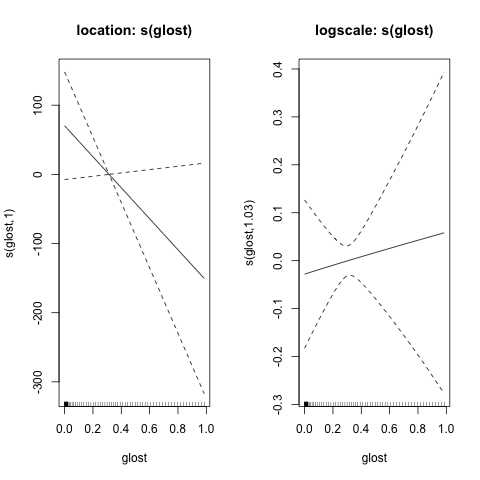


** Parametric terms **

location
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  1241.84      40.62   30.57   <2e-16

logscale
            Estimate Std. Error t value Pr(>|t|)
(Intercept)     5.81       0.09   65.24   <2e-16

shape
            Estimate Std. Error t value Pr(>|t|)
(Intercept)    -0.33       0.08   -4.11 1.99e-05

** Smooth terms **

location
         edf max.df Chi.sq Pr(>|t|)
s(glost)   1      4   3.26    0.071

logscale
          edf max.df Chi.sq Pr(>|t|)
s(glost) 1.03      4   0.13     0.73
#############
#############
Point 2
#############
#############


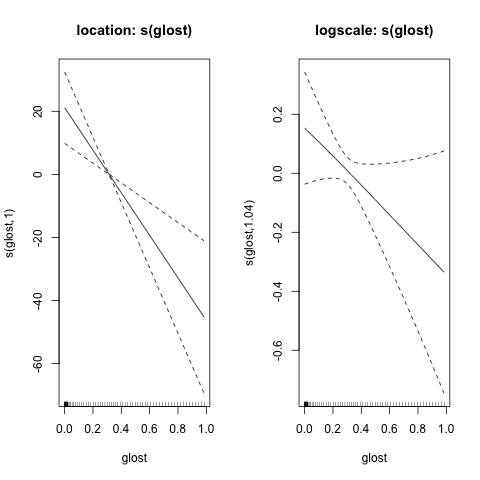


** Parametric terms **

location
            Estimate Std. Error t value Pr(>|t|)
(Intercept)    99.13       6.92   14.32   <2e-16

logscale
            Estimate Std. Error t value Pr(>|t|)
(Intercept)     3.98        0.1   40.78   <2e-16

shape
            Estimate Std. Error t value Pr(>|t|)
(Intercept)     0.09        0.1    0.95     0.17

** Smooth terms **

location
         edf max.df Chi.sq Pr(>|t|)
s(glost)   1      4  13.99 0.000184

logscale
          edf max.df Chi.sq Pr(>|t|)
s(glost) 1.04      4   2.78    0.104


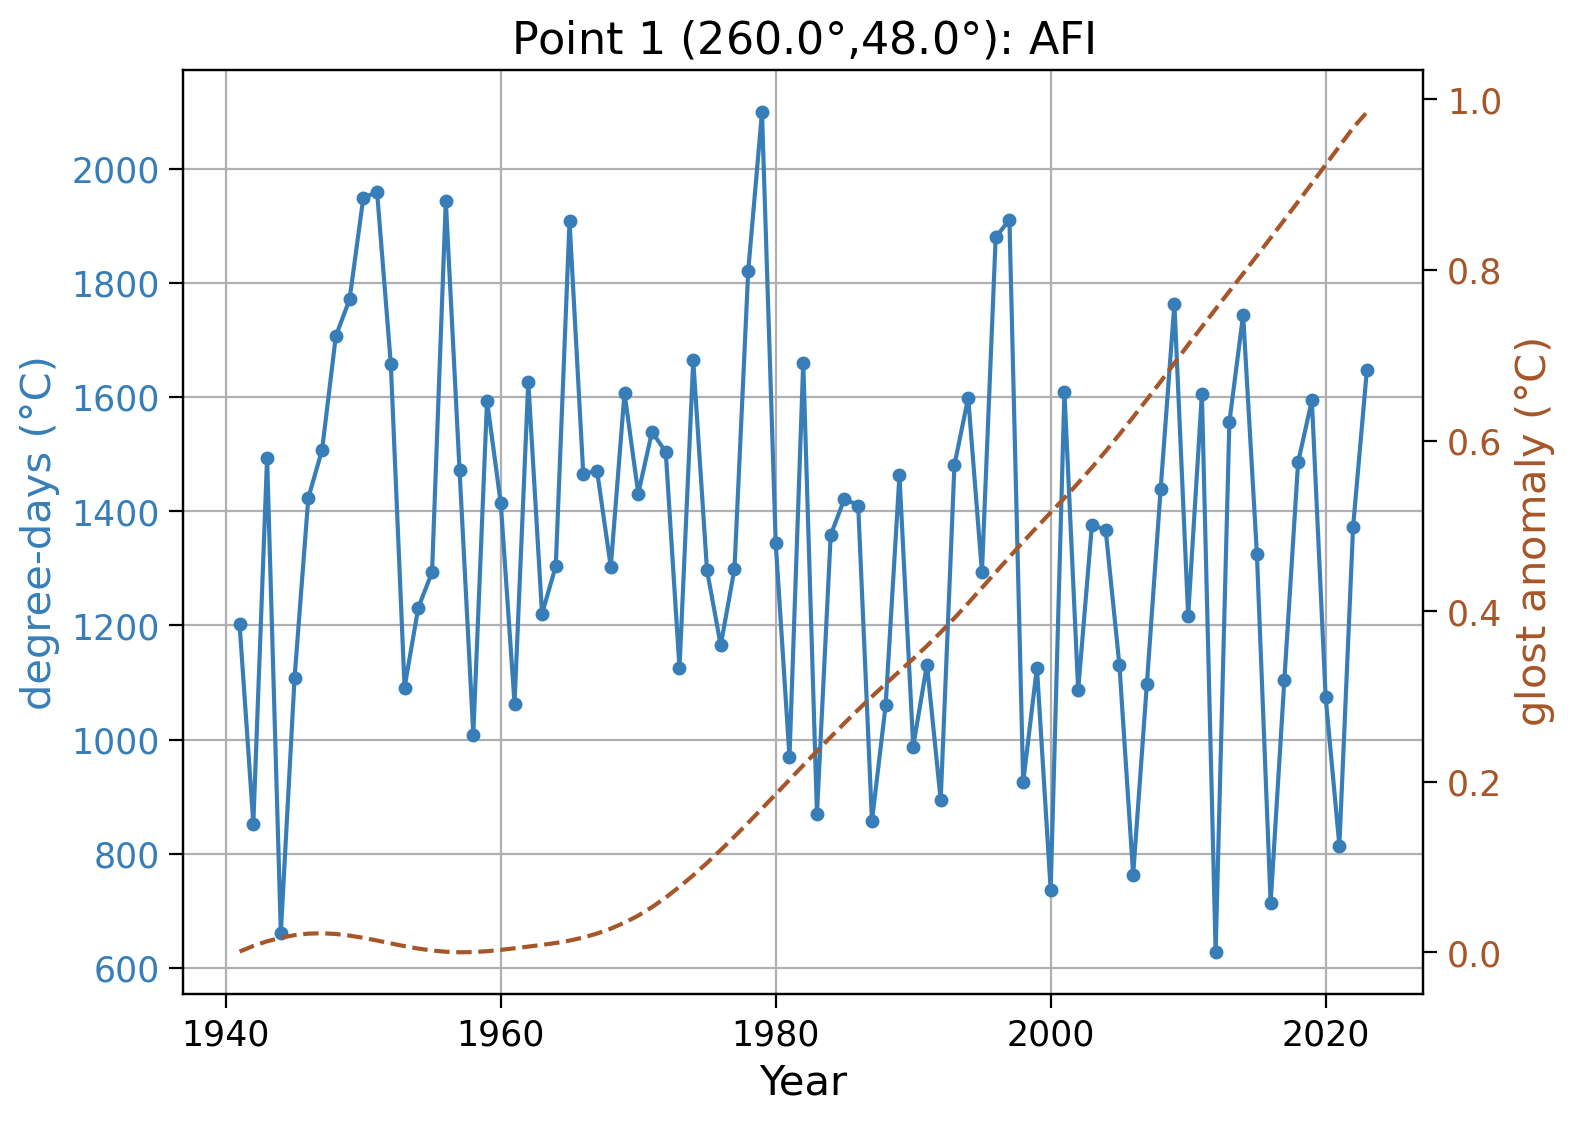

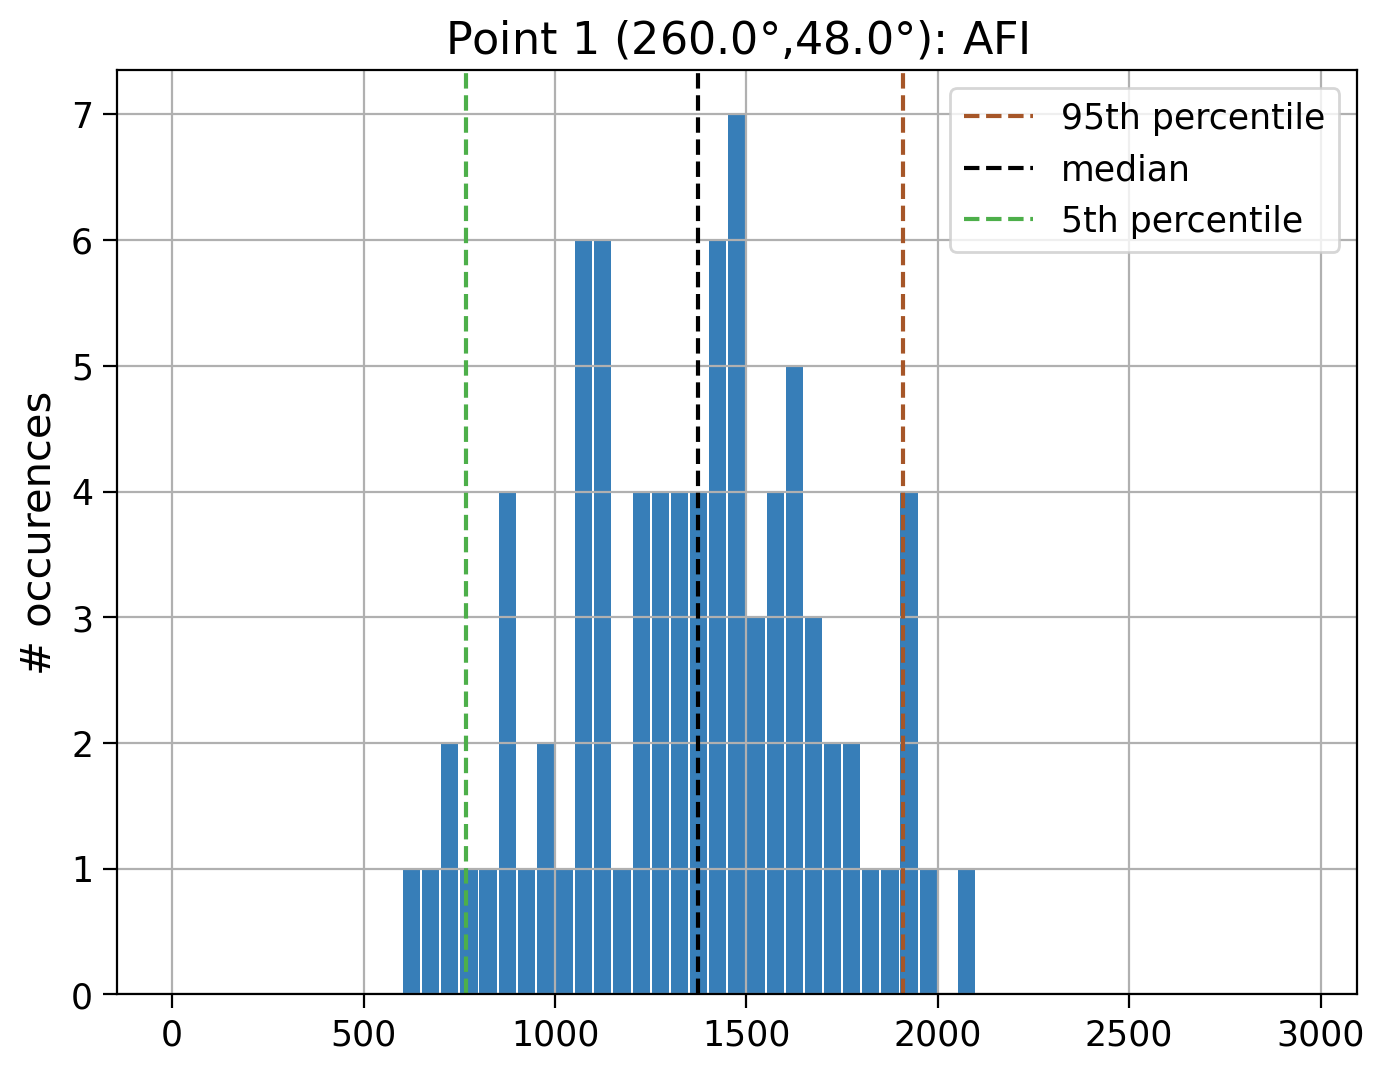

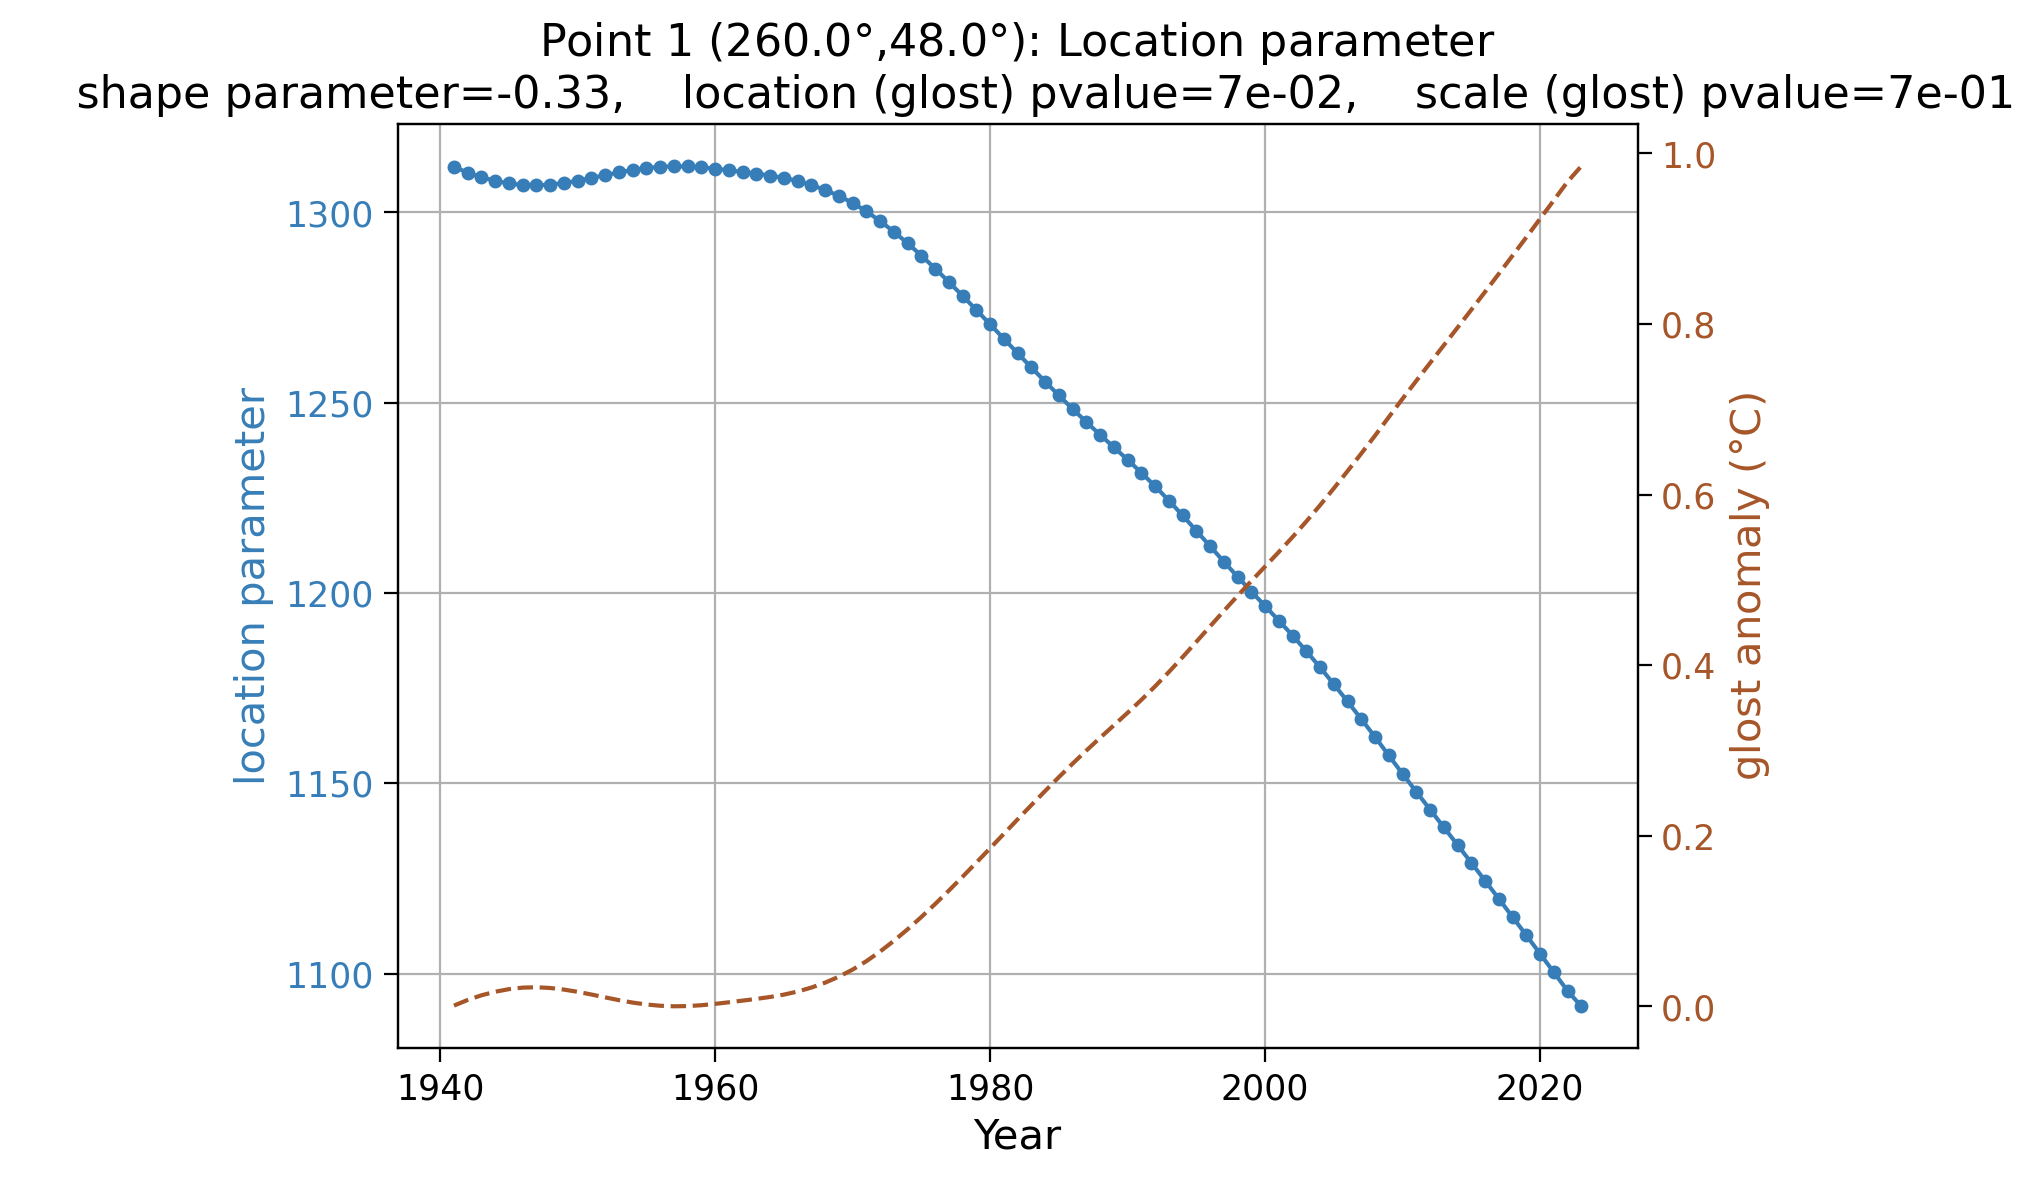

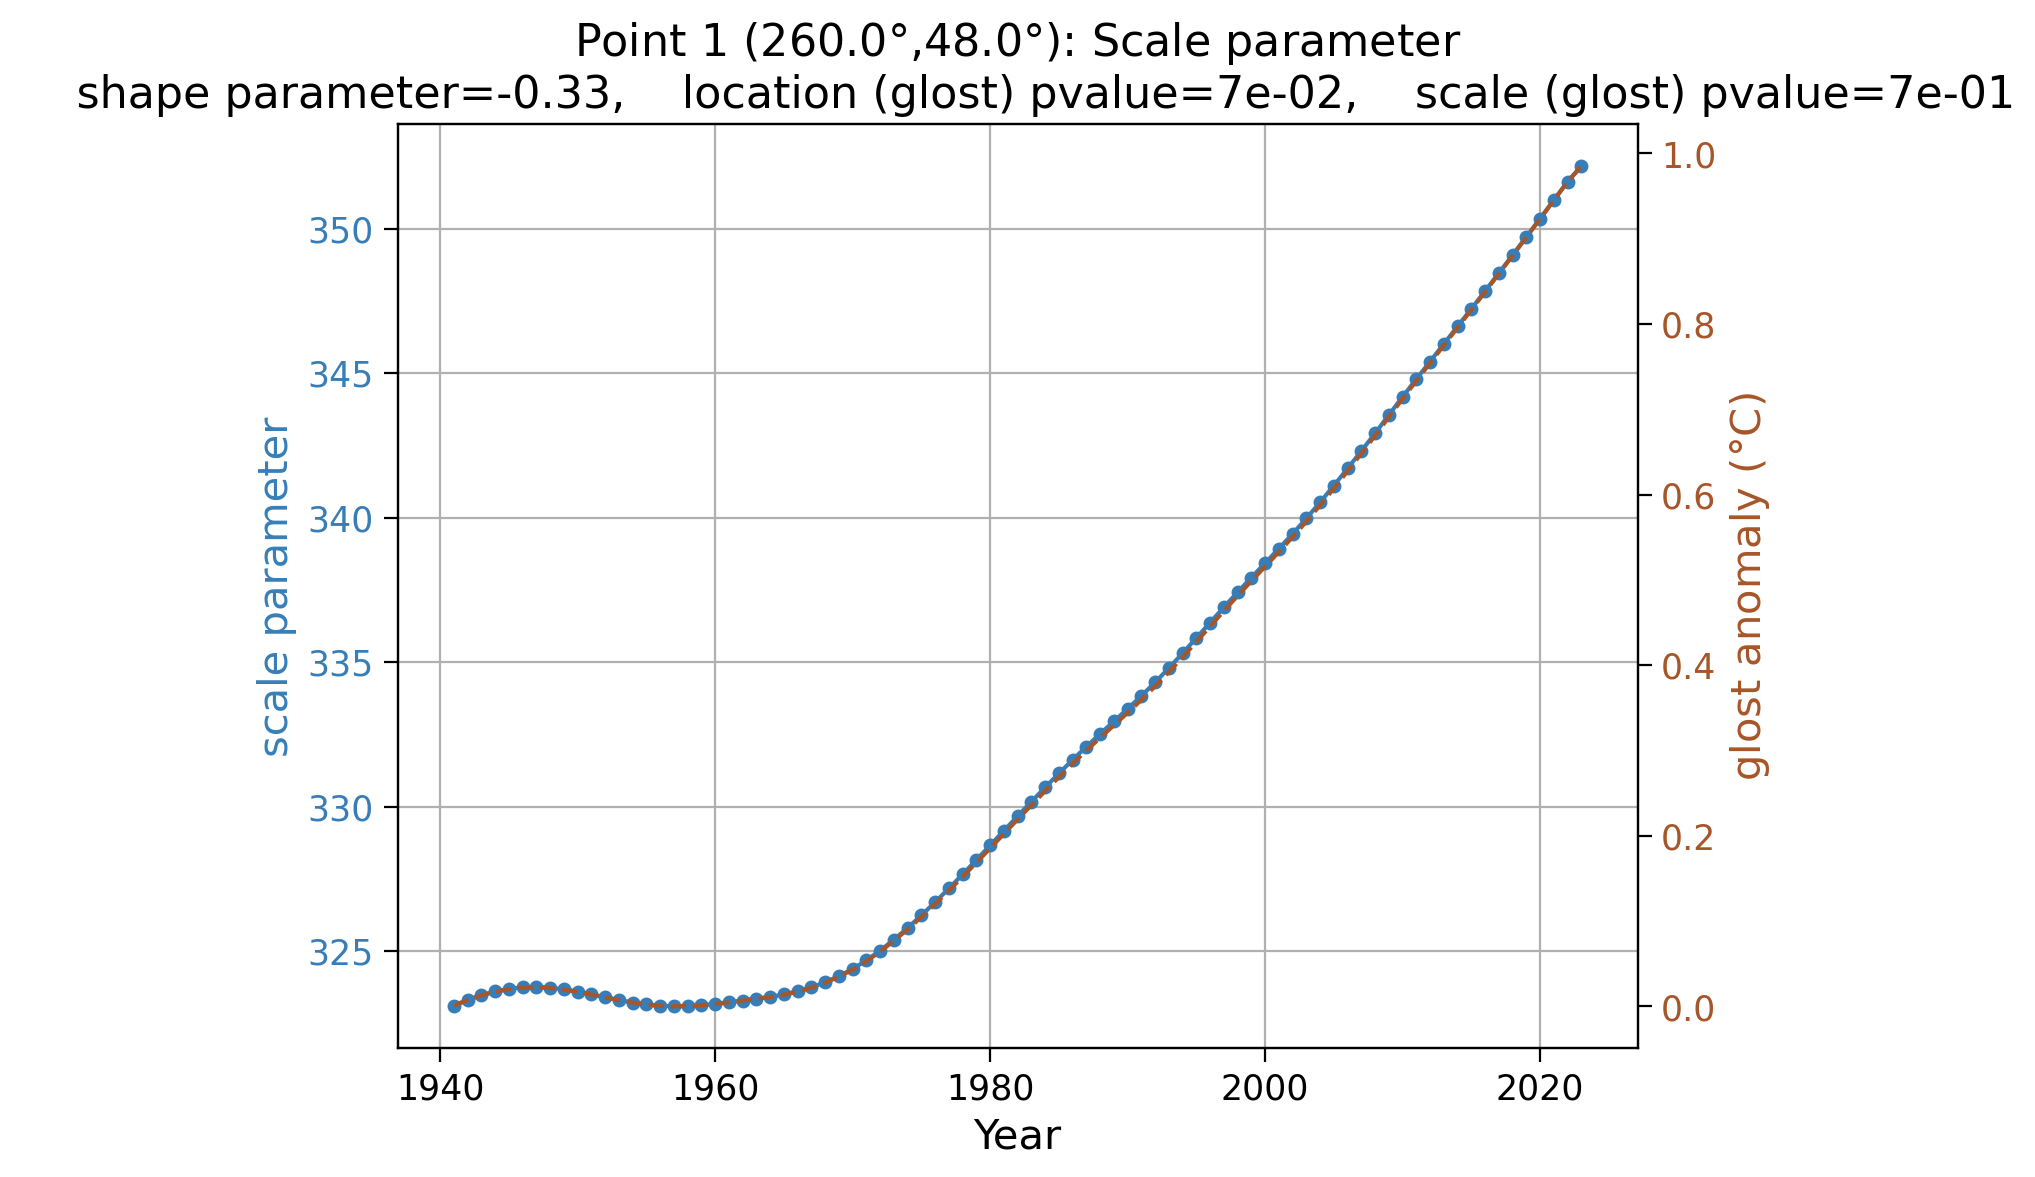

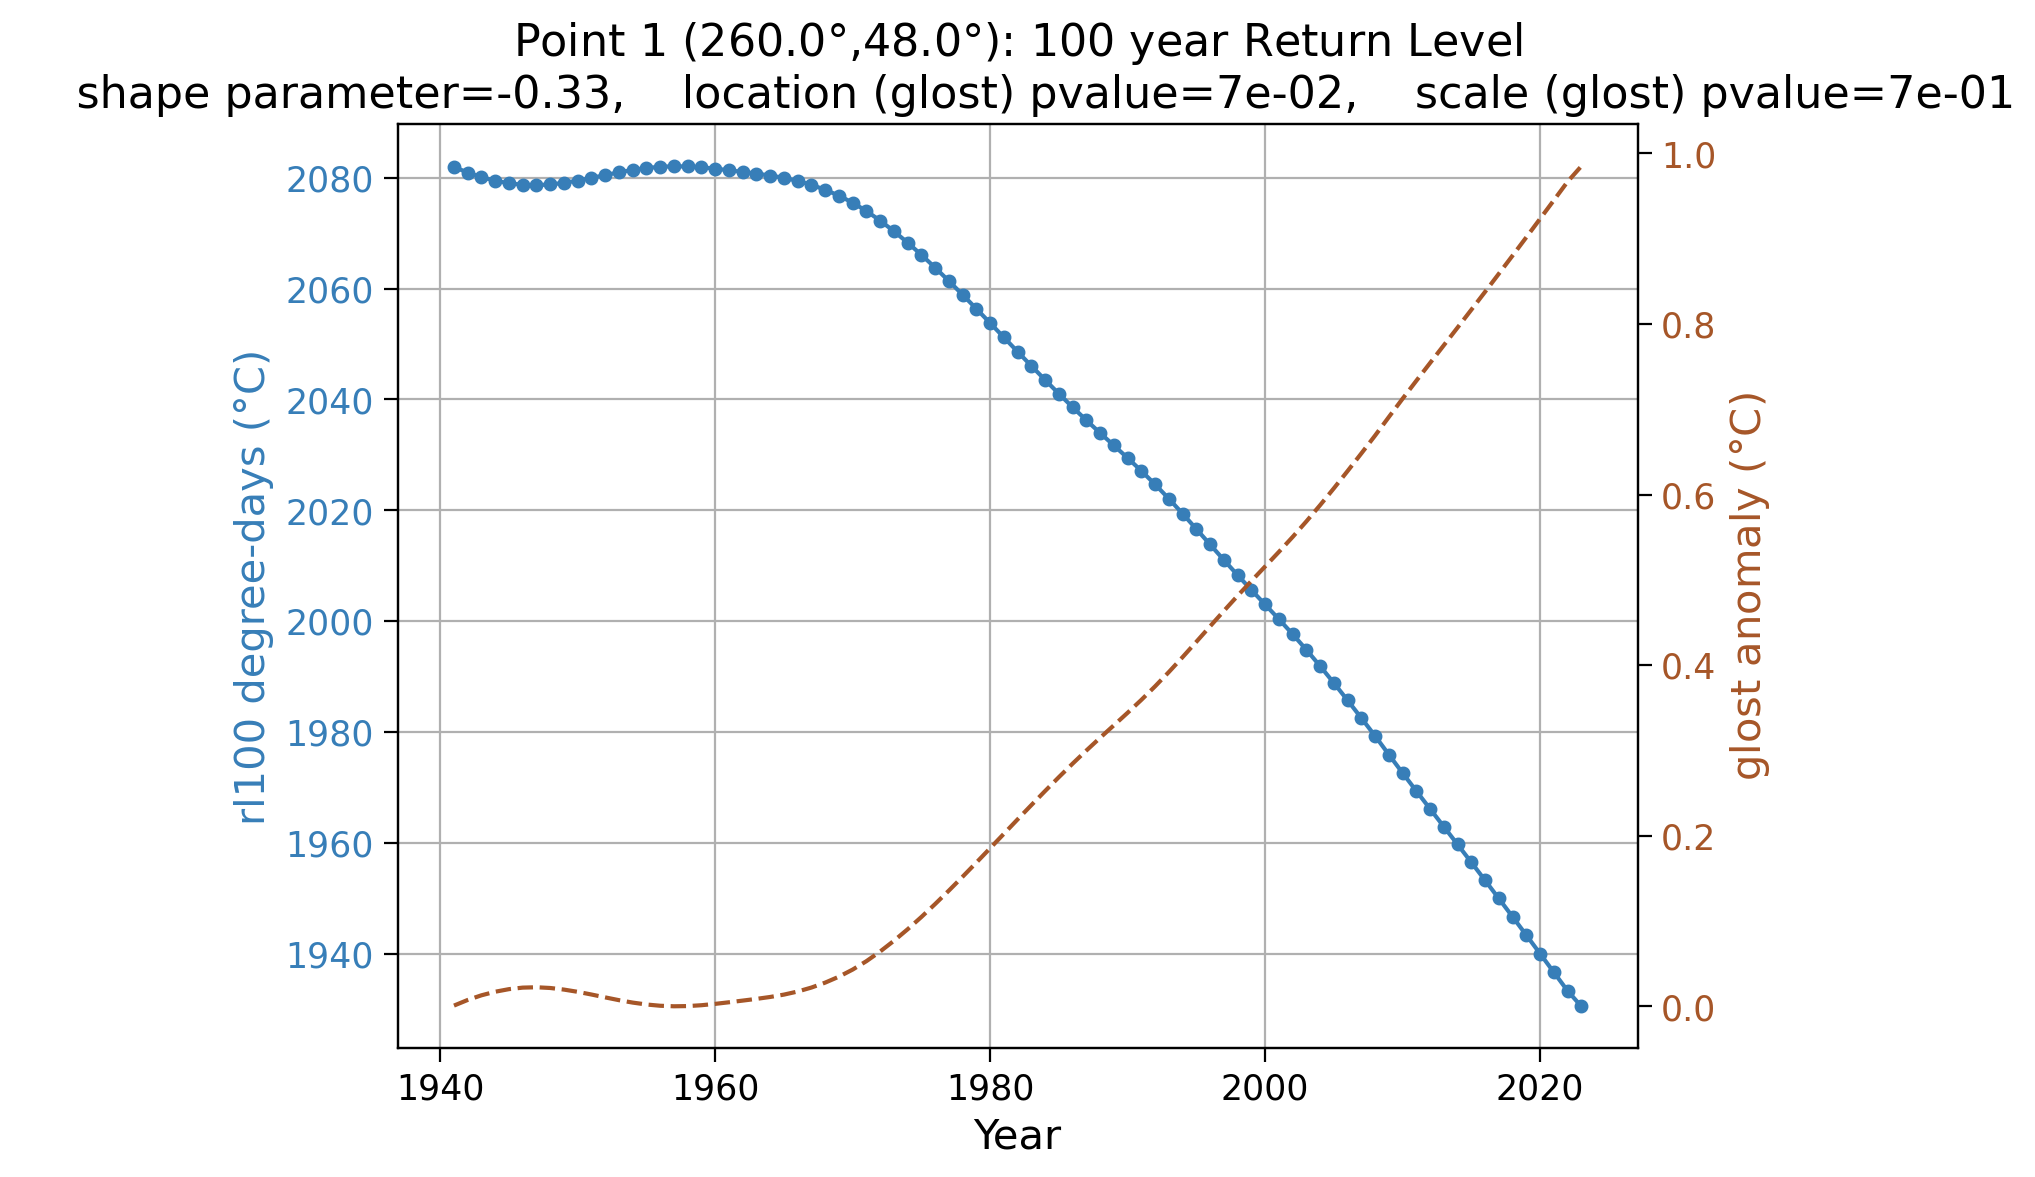

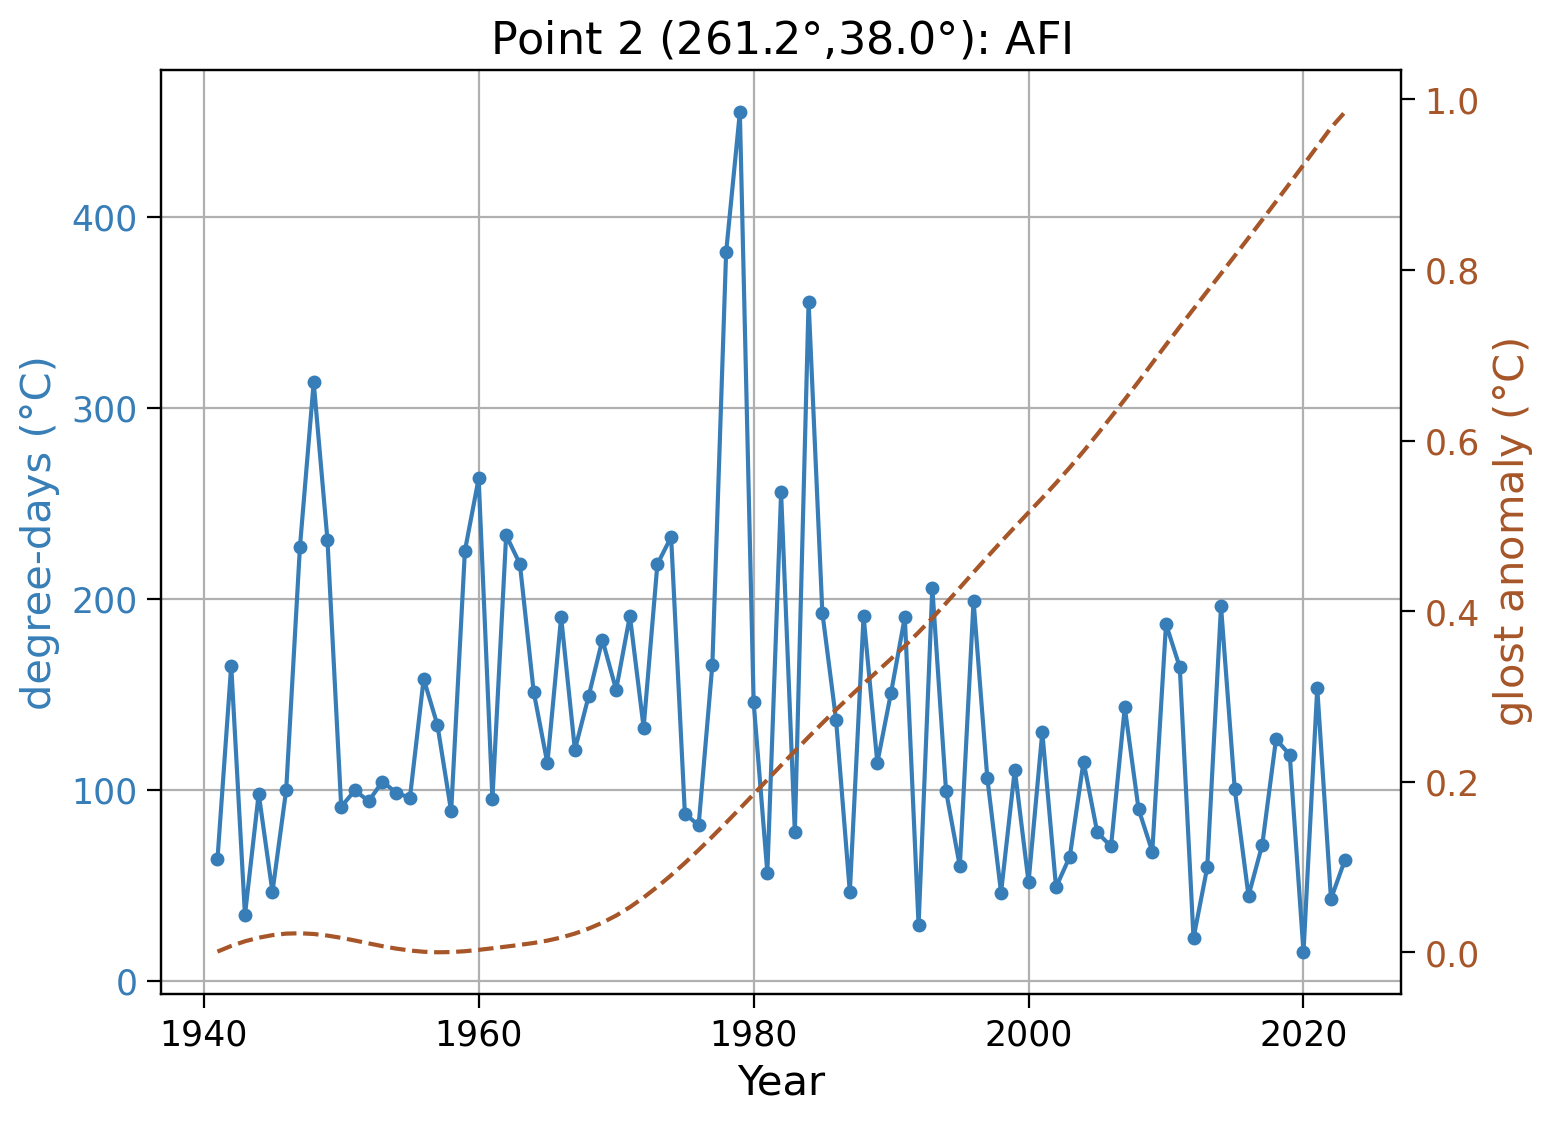

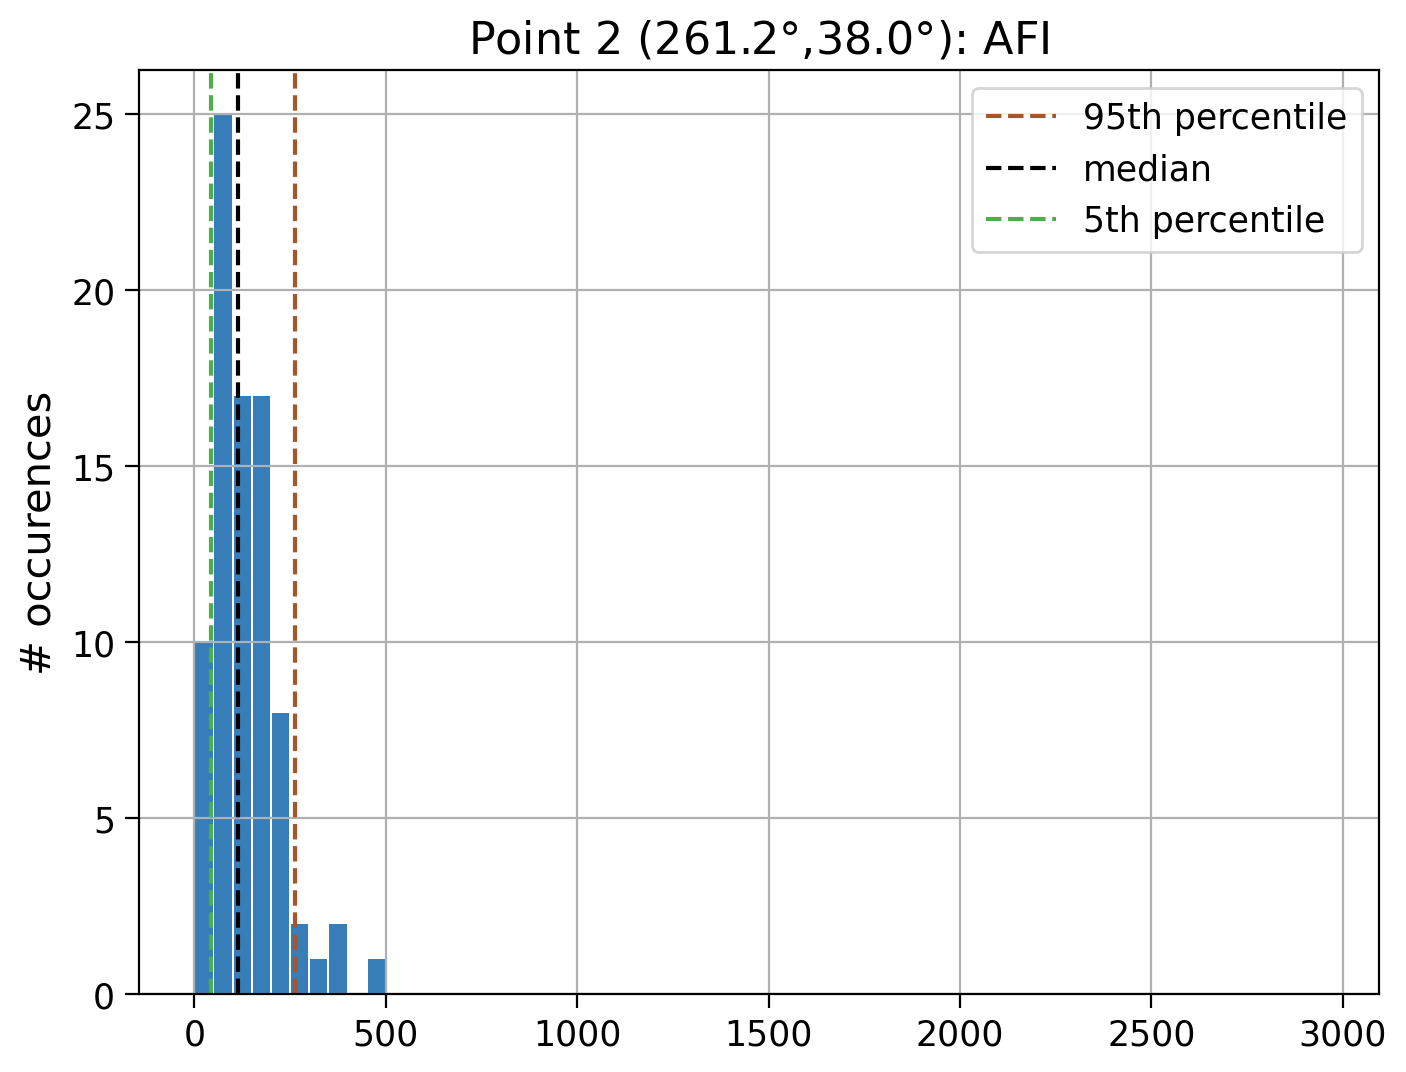

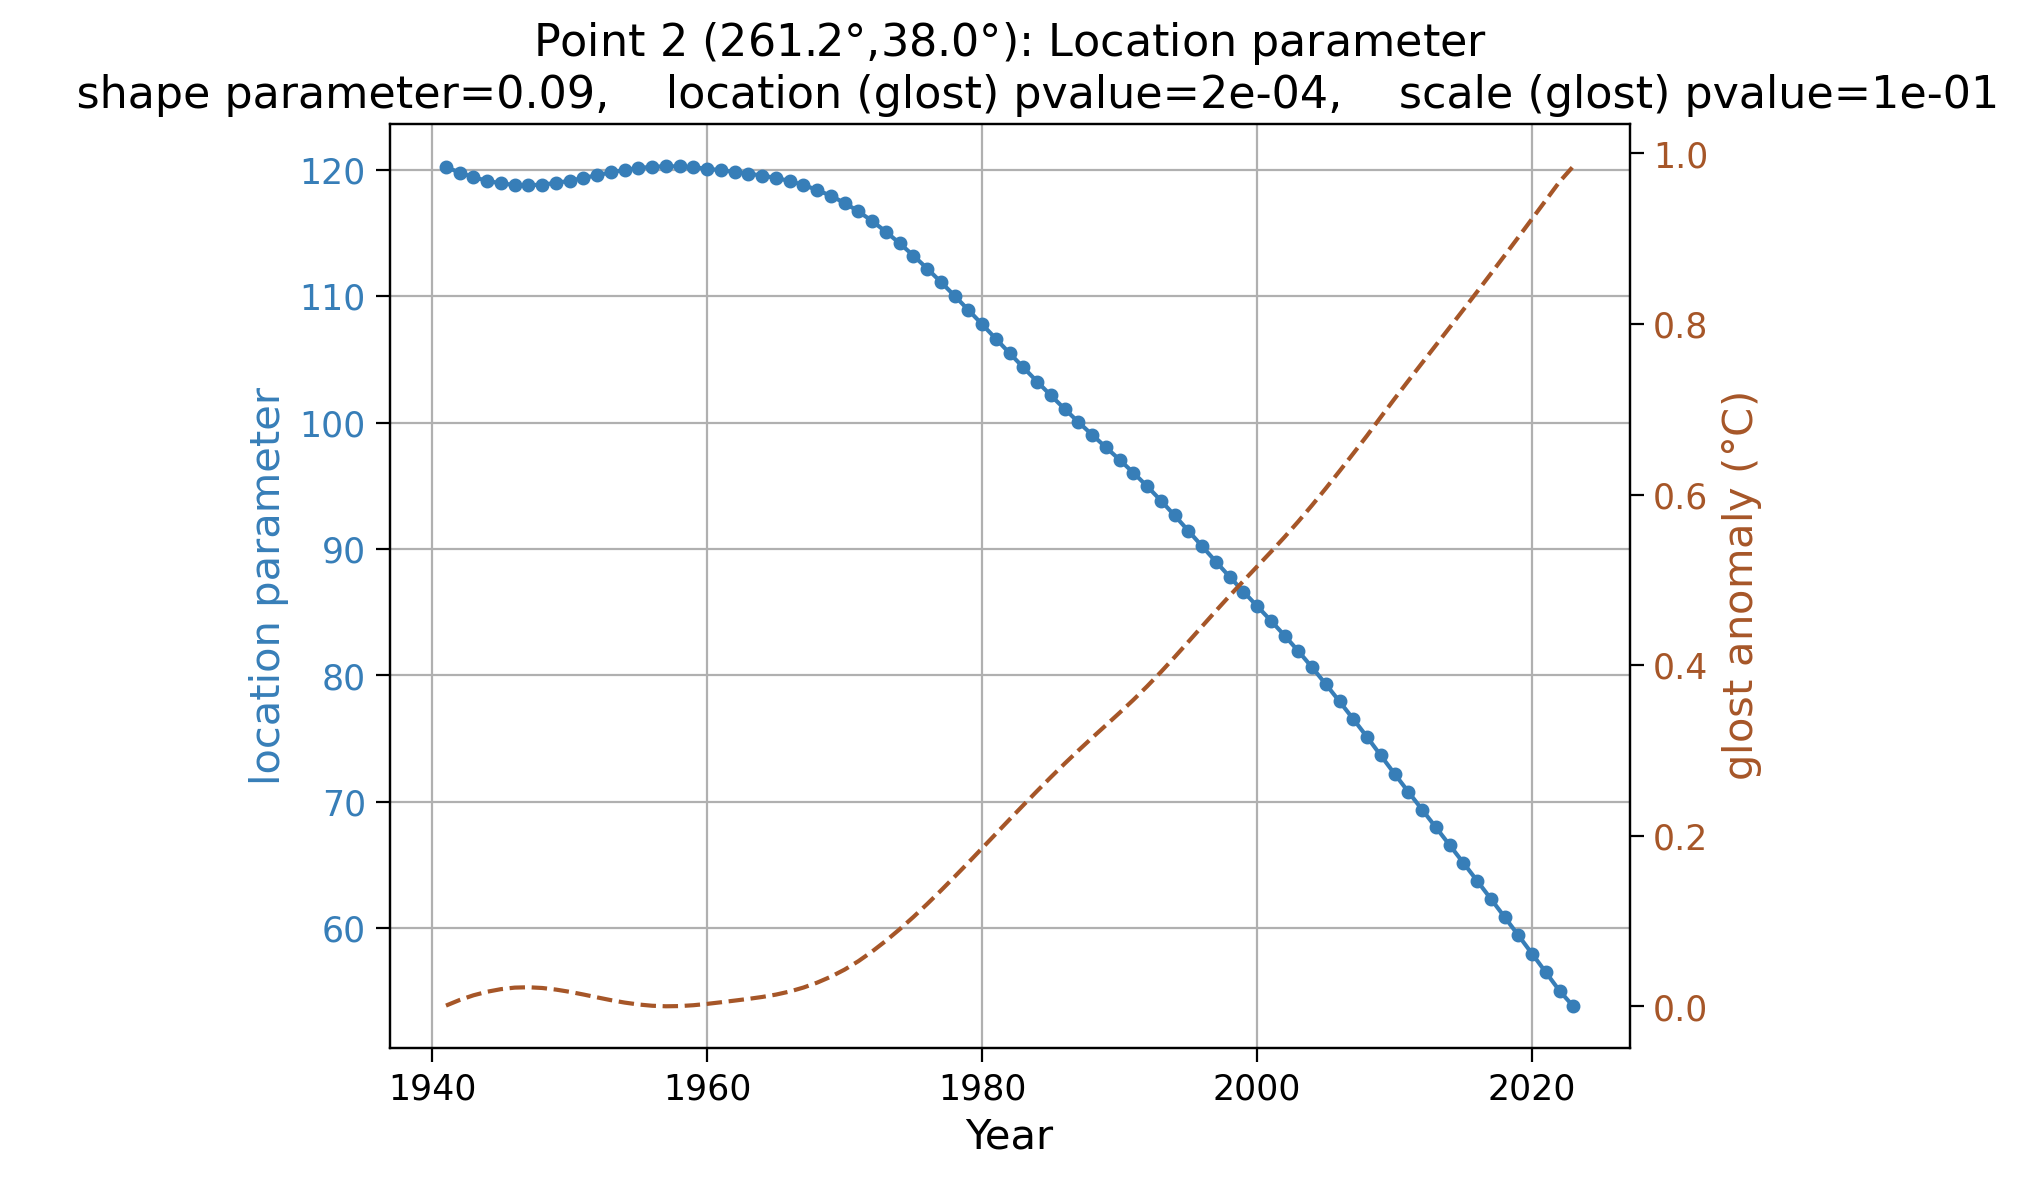

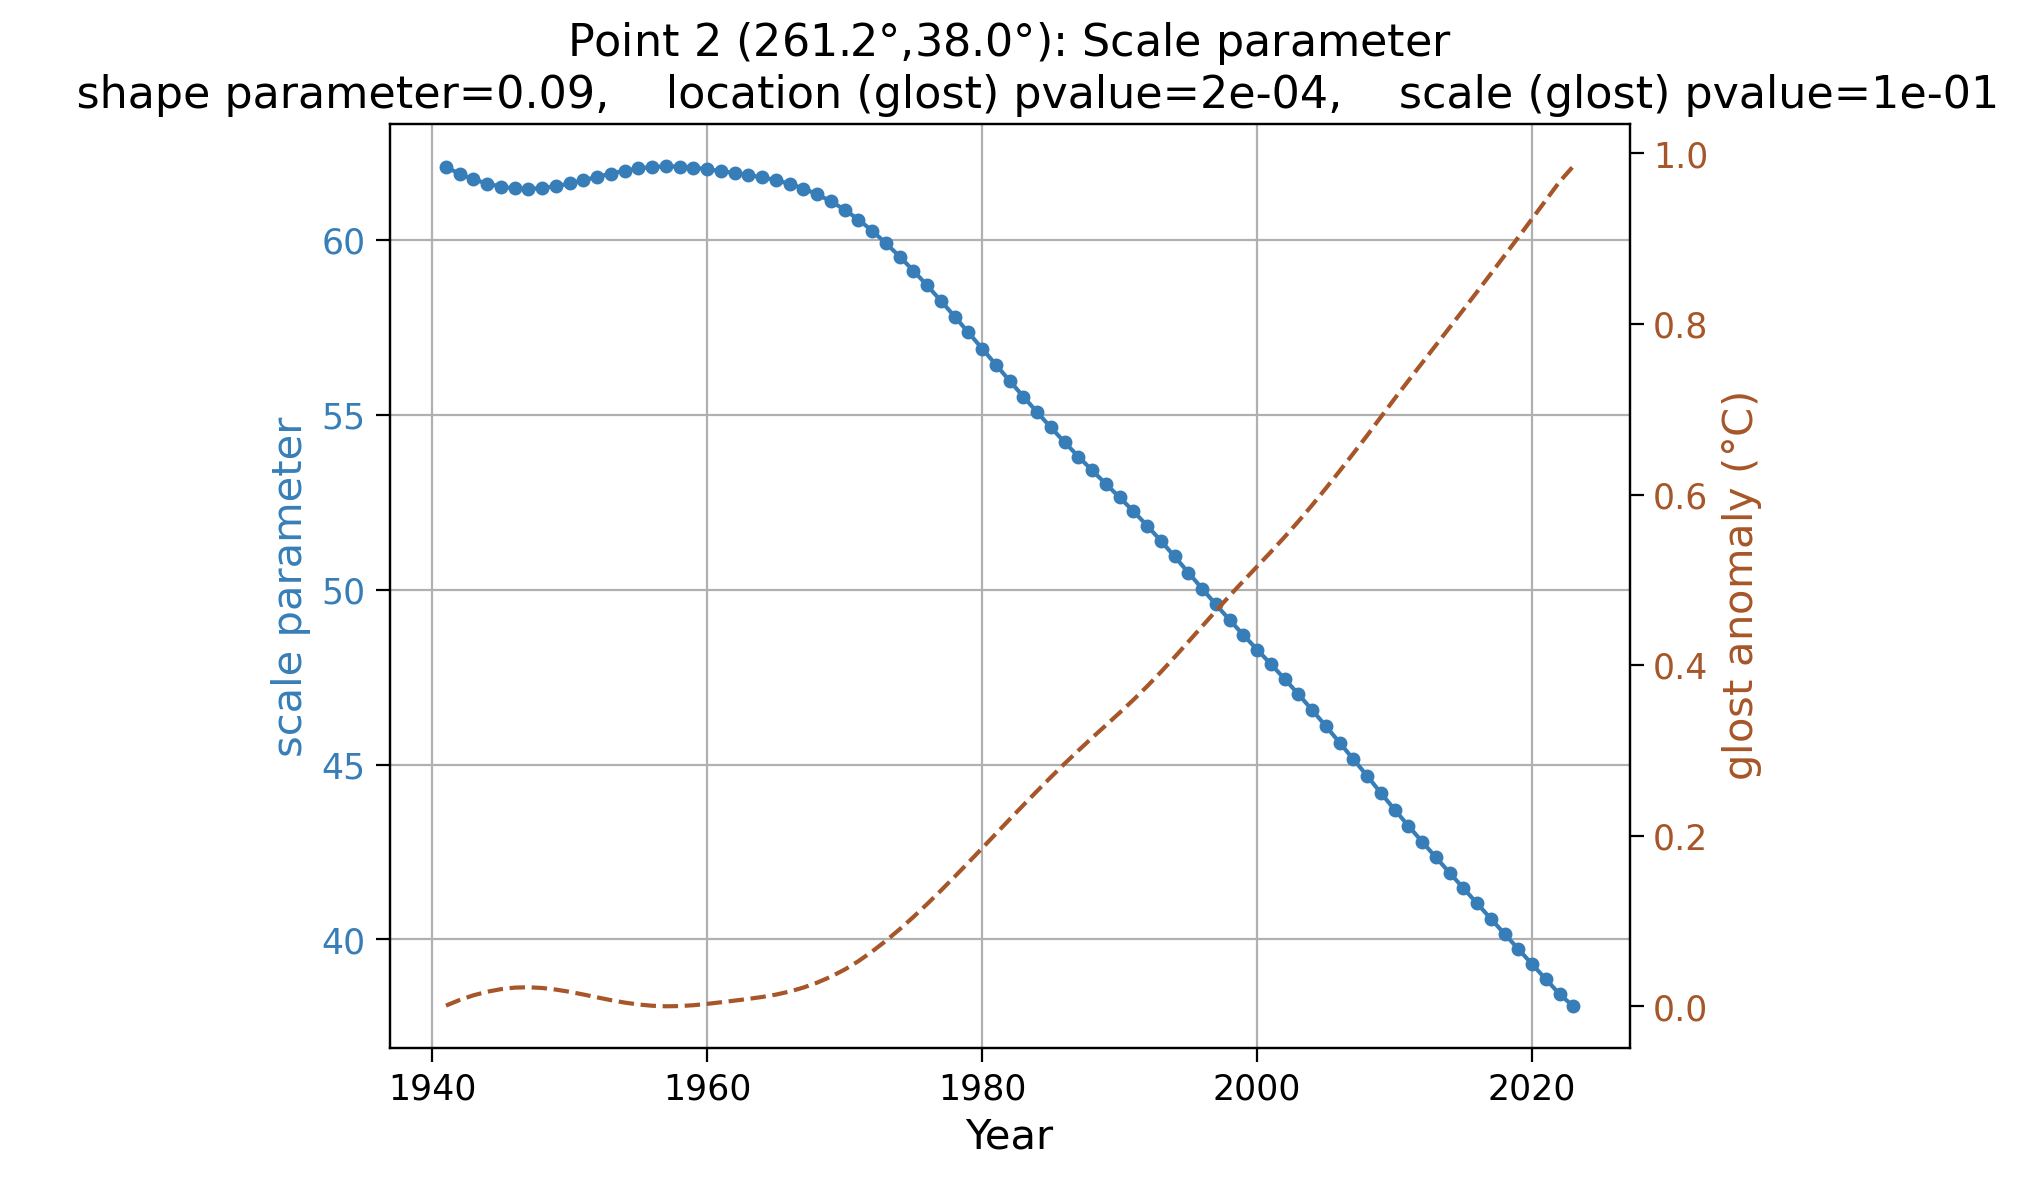

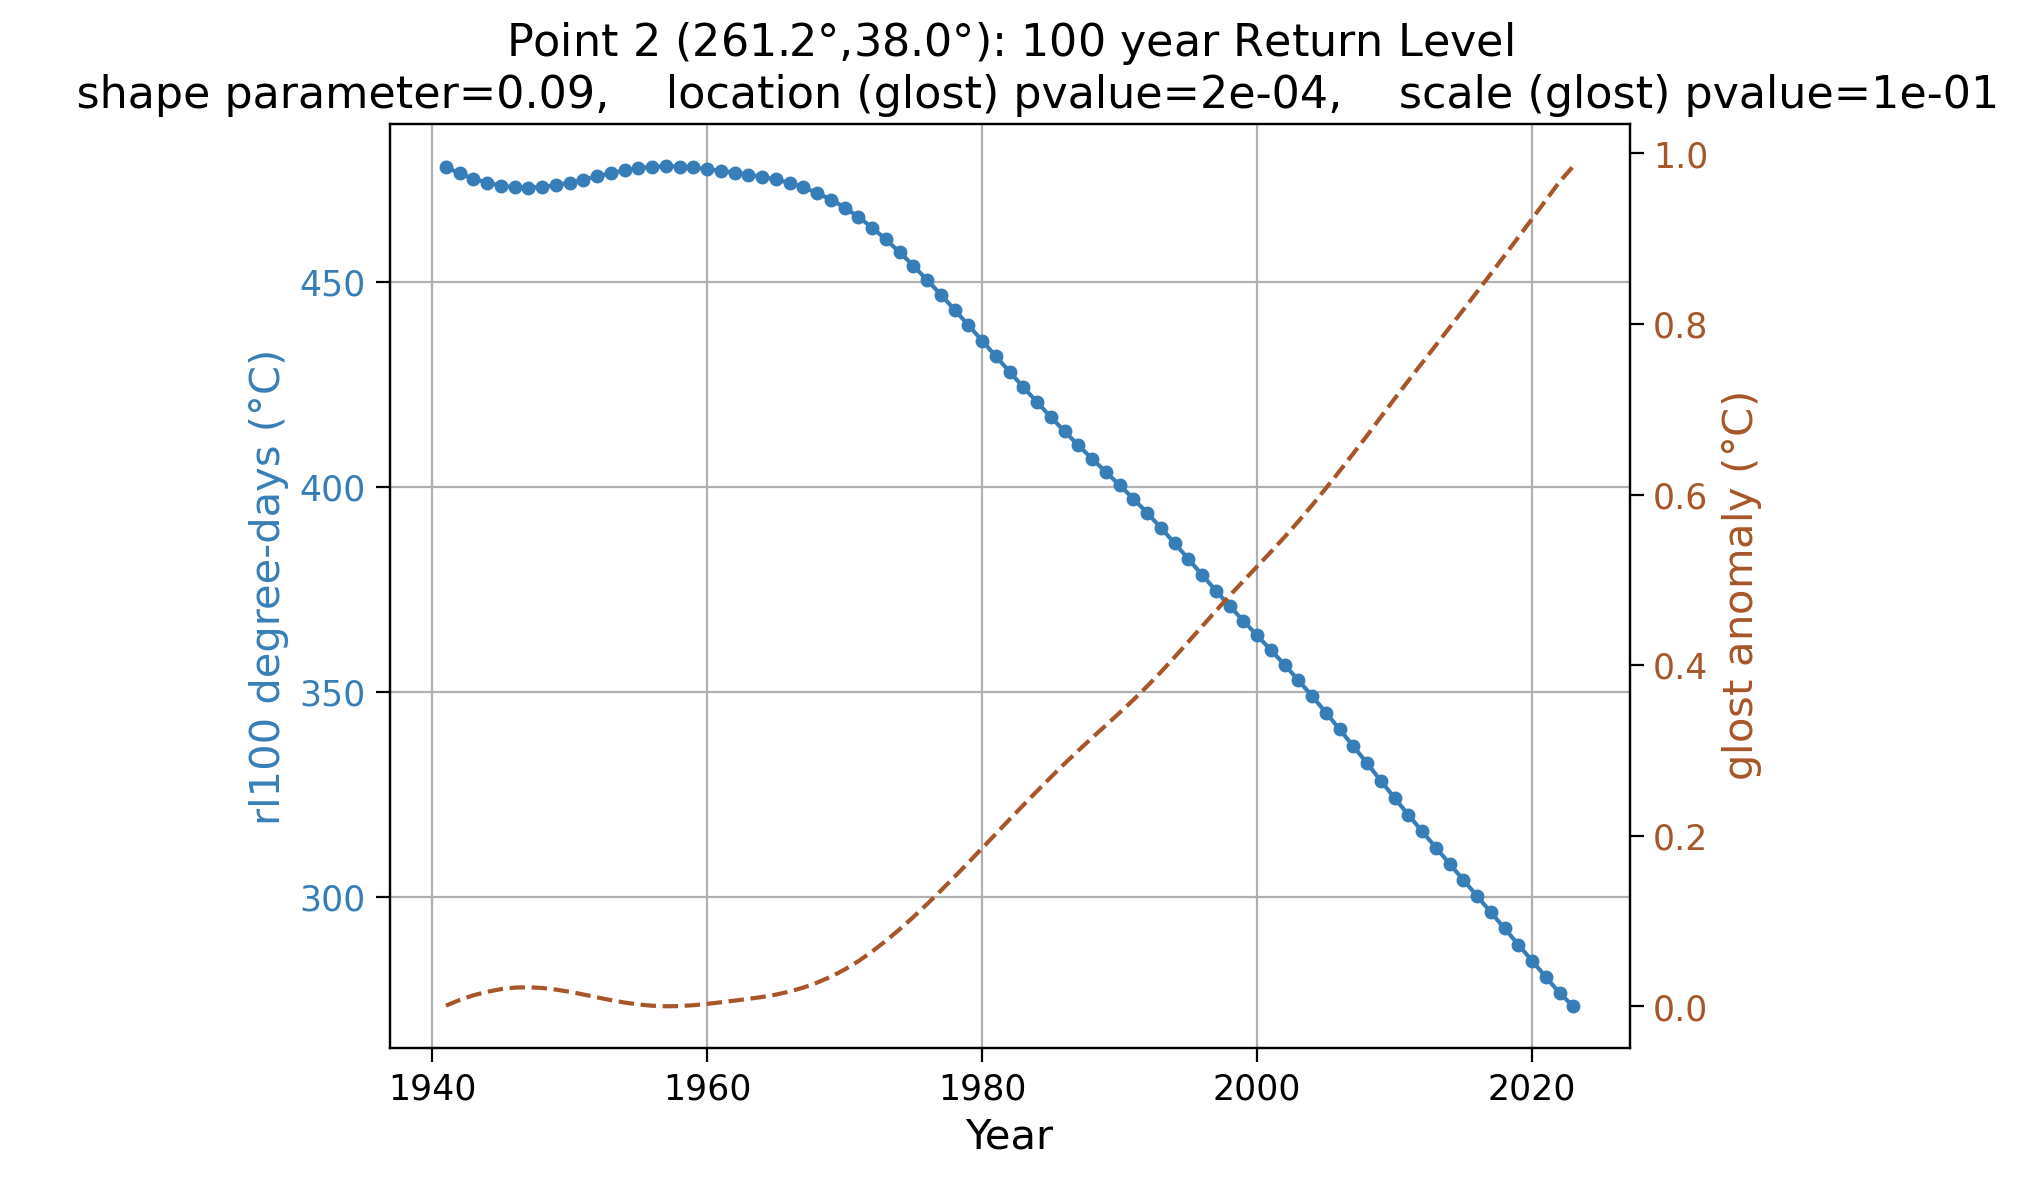

In [144]:
bins=np.arange(0,3000,50)

for ij in range(0,len(ptlon)):
  ilon=ptlon[ij]
  ilat=ptlat[ij]
  # Extract values for boxes
  dsij=dsa.sel(lon=ilon,lat=ilat).load()
  df = dsij.to_dataframe()
  df = df.reset_index()
  # Remove zeros and NAN 
  # Remove timeseries with less than 15 data (as in Bilotta et al.)
  # Save rows removed
  dfsave=df[(df['AFI'] <= 0.)|(df['AFI'].isna())]
  df = df[df['AFI'] > 0.]

  dfsave=pd.concat([dfsave, df.groupby(['lon', 'lat']).filter(lambda x: len(x) <= 49)])
  df=df.groupby(['lon', 'lat']).filter(lambda x: len(x) > 49)
  # Convert xarray to pandas DataFrame to R data.frame
  # You can now work with 'r_df' in R

  r_df = ro.conversion.py2rpy(df)
  globalenv['r_df'] = r_df

  # EVGAM model fitting  
  %R m_gev <- evgam(fmla_gev, r_df, family = "gev")
  %R gev_pred <- predict(m_gev, r_df, type = "response")
  %R gev_rl100 <- predict(m_gev, r_df, prob = 0.99)
  print('#############')
  print('#############')
  print(f'Point {ij+1}')
  print('#############')
  print('#############')

  %R plot(m_gev)
  %R pp<-summary(m_gev)
  %R location_pvalue <- pp[[2]][['location']][['Pr(>|t|)']]
  %R scale_pvalue <- pp[[2]][['logscale']][['Pr(>|t|)']]
  %R print(pp)
  %R -o gev_pred,pp,gev_rl100,location_pvalue,scale_pvalue

  #####
  # PLOTS
  #####
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(np.arange(yearb,yeare+1,1),dsij['AFI'],color='#377eb8',marker='o',markersize=4)
  ax1.set_ylabel(f'{units}', color='#377eb8')
  ax1.tick_params(axis='y', labelcolor='#377eb8')
  ax1.set_xlabel('Year')
  ax1.grid()
  ax2.plot(np.arange(yearb,yeare+1,1),ann_glost,linestyle='--',color='#a65628',label='glost anomaly')
  ax2.set_ylabel('glost anomaly ($\degree$C)', color='#a65628')
  ax2.tick_params(axis='y', labelcolor='#a65628')
  ax1.set_title(f'Point {ij+1} ({ilon:0.1f}$\degree$,{ilat:0.1f}$\degree$): AFI',fontsize=16)
  outfile=f'PLOTS/AFI_glost_timeseries_NS{itest}_pt{ij+1}.png'
  plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')
  ######  
  d1=histogram(dsij['AFI'], bins=bins, block_size=None)
  per90th=dsij['AFI'].quantile(0.95)
  per50th=dsij['AFI'].quantile(0.5)
  per10th=dsij['AFI'].quantile(0.05)
  fig, axs = plt.subplots()
  axs.bar((bins[1:]+bins[:-1])*0.5,d1.data,color='#377eb8',width=45)
  axs.axvline(per90th,color='#a65628', linewidth=1.5,linestyle='--', label="95th percentile" )
  axs.axvline(per50th,color='black',linewidth=1.5,linestyle='--', label="median")
  axs.axvline(per10th,color='#4daf4a',  linewidth=1.5,linestyle='--', label="5th percentile" )
  axs.set_ylabel('# occurences', color='k')
  axs.grid()
  plt.legend(loc='best')
  axs.set_title(f'Point {ij+1} ({ilon:0.1f}$\degree$,{ilat:0.1f}$\degree$): AFI',fontsize=16)
  outfile=f'PLOTS/AFI_glost_histogram_NS{itest}_pt{ij+1}.png'
  plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')
  ######
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(np.arange(yearb,yeare+1,1),gev_pred['location'],color='#377eb8',marker='o',markersize=4)
  ax1.set_ylabel(f'location parameter', color='#377eb8')
  ax1.tick_params(axis='y', labelcolor='#377eb8')
  ax2.plot(np.arange(yearb,yeare+1,1),ann_glost,linestyle='--',color='#a65628',label='glost anomaly')
  ax2.set_ylabel('glost anomaly ($\degree$C)', color='#a65628')
  ax2.tick_params(axis='y', labelcolor='#a65628')
  ax1.set_xlabel('Year')
  ax1.grid()
  ax1.set_title(f'Point {ij+1} ({ilon:0.1f}$\degree$,{ilat:0.1f}$\degree$): Location parameter\n\
    shape parameter={gev_pred['shape'].mean():0.2f},\
    location (glost) pvalue={location_pvalue[0]:.0e},\
    scale (glost) pvalue={scale_pvalue[0]:.0e}',fontsize=16)
  outfile=f'PLOTS/location_glost_timeseries_NS{itest}_pt{ij+1}.png'
  plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')
  ######
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(np.arange(yearb,yeare+1,1),gev_pred['scale'],color='#377eb8',marker='o',markersize=4)
  ax1.set_ylabel(f'scale parameter', color='#377eb8')
  ax1.tick_params(axis='y', labelcolor='#377eb8')
  ax2.plot(np.arange(yearb,yeare+1,1),ann_glost,linestyle='--',color='#a65628',label='glost anomaly')
  ax2.set_ylabel('glost anomaly ($\degree$C)', color='#a65628')
  ax2.tick_params(axis='y', labelcolor='#a65628')
  ax1.set_xlabel('Year')
  ax1.grid()
  ax1.set_title(f'Point {ij+1} ({ilon:0.1f}$\degree$,{ilat:0.1f}$\degree$): Scale parameter\n\
    shape parameter={gev_pred['shape'].mean():0.2f},\
    location (glost) pvalue={location_pvalue[0]:.0e},\
    scale (glost) pvalue={scale_pvalue[0]:.0e}',fontsize=16)
  outfile=f'PLOTS/scale_glost_timeseries_NS{itest}_pt{ij+1}.png'
  plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')
  ######
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(np.arange(yearb,yeare+1,1),gev_rl100['q:0.99'],color='#377eb8',marker='o',markersize=4)
  ax1.set_ylabel(f'rl100 {units}', color='#377eb8')
  ax1.tick_params(axis='y', labelcolor='#377eb8')
  ax2.plot(np.arange(yearb,yeare+1,1),ann_glost,linestyle='--',color='#a65628',label='glost anomaly')
  ax2.set_ylabel('glost anomaly ($\degree$C)', color='#a65628')
  ax2.tick_params(axis='y', labelcolor='#a65628')
  ax1.set_xlabel('Year')
  ax1.grid()
  ax1.set_title(f'Point {ij+1} ({ilon:0.1f}$\degree$,{ilat:0.1f}$\degree$): 100 year Return Level\n\
    shape parameter={gev_pred['shape'].mean():0.2f},\
    location (glost) pvalue={location_pvalue[0]:.0e},\
    scale (glost) pvalue={scale_pvalue[0]:.0e}',fontsize=16)
  outfile=f'PLOTS/rl100_glost_timeseries_NS{itest}_pt{ij+1}.png'
  plt.savefig(outfile, dpi=150, facecolor='w', edgecolor='w', orientation='portrait')